# Chapter 1. The Python Data Model

The Python interpreter invokes special methods to perform basic object operations, often triggered by special syntax. The special method names are always written with leading and trailing double underscores (i.e., __getitem__). For example, the syntax `obj[key]` is supported by the `__getitem__` special method. In order to evaluate `my_collection[key]`, the interpreter calls `my_collection.__getitem__(key)`.

The special method names allow your objects to implement, support, and interact with basic language constructs such as:
- Iteration
- Collections
- Attribute access
- Operator overloading
- Function and method invocation
- Object creation and destruction
- String representation and formatting
- Managed contexts (i.e., `with` blocks)

### A Pythonic Card Deck

The following is a simple example demonstrating the power of two special methods, `__getitem__` and `__len__`.

**Example 1-1** is a class to represent a deck of playing cards.

*Example 1-1. A deck as a sequence of cards*

In [1]:
import collections

Card = collections.namedtuple('Card',['rank','suit'])

class FrenchDeck:
    ranks = [str(n) for n in range(2,11)] + list('JQKA')
    suits = 'spades diamonds clubs hearts'.split()
    
    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits
                                        for rank in self.ranks]
        
    def __len__(self):
        return len(self._cards)
    
    def __getitem__(self, position):
        return self._cards[position]

In [2]:
beer_card = Card('7', 'diamonds')
beer_card

Card(rank='7', suit='diamonds')

In [3]:
deck = FrenchDeck()
len(deck)

52

Reading specific cards from the deck - say the first or the last - should be as easy as `deck[0]` or `deck[-1]`, and this is what the `__getitem__` method provides:

In [4]:
deck[0]

Card(rank='2', suit='spades')

In [5]:
deck[-1]

Card(rank='A', suit='hearts')

Python already has a function we can use to get a random item from a sequence: `random.choice`. We can just use it on a deck instance:

In [6]:
from random import choice
choice(deck)

Card(rank='K', suit='diamonds')

In [7]:
choice(deck)

Card(rank='K', suit='clubs')

In [8]:
choice(deck)

Card(rank='J', suit='hearts')

So far, two advantages of using special methods to leverage the Python data model:
- Users don't have to memorize arbitrary method names for standard operations
- It's easier to use the Python standard library than having to reinvent the wheel

Because `__getitem__` delegates to the `[]` operator of `self._cards`, our deck automatically supports slicing. Here's how to pick the top three cards from a brand new deck, and then pick just the aces by starting on index 12 and skipping 13 cards at a time:

In [9]:
deck[:3]

[Card(rank='2', suit='spades'),
 Card(rank='3', suit='spades'),
 Card(rank='4', suit='spades')]

In [10]:
deck[12::13]

[Card(rank='A', suit='spades'),
 Card(rank='A', suit='diamonds'),
 Card(rank='A', suit='clubs'),
 Card(rank='A', suit='hearts')]

By implementing the `__getitem__` special method, our deck is also iterable:

In [11]:
for card in deck[:10]:
    print(card)

Card(rank='2', suit='spades')
Card(rank='3', suit='spades')
Card(rank='4', suit='spades')
Card(rank='5', suit='spades')
Card(rank='6', suit='spades')
Card(rank='7', suit='spades')
Card(rank='8', suit='spades')
Card(rank='9', suit='spades')
Card(rank='10', suit='spades')
Card(rank='J', suit='spades')


The deck can also be iterated in reverse:

In [12]:
for card in reversed(deck[:10]):
    print(card)

Card(rank='J', suit='spades')
Card(rank='10', suit='spades')
Card(rank='9', suit='spades')
Card(rank='8', suit='spades')
Card(rank='7', suit='spades')
Card(rank='6', suit='spades')
Card(rank='5', suit='spades')
Card(rank='4', suit='spades')
Card(rank='3', suit='spades')
Card(rank='2', suit='spades')


Iteration is often implicit. If a collection has no `__containts__` method, the `in` operator does a sequential scan. Case in point: `in` works without our `FrenchDeck` because it is iterable:

In [14]:
Card('Q', 'hearts') in deck

True

In [15]:
Card('7', 'beasts') in deck

False

How about sorting? A common system of ranking cards is by rank, then by suit, then spades/hearts/diamonds/clubs. Here is a function that ranks cards by that rule, returning 0 for the 2 of clubs and 51 for the ace of spades:

In [16]:
suit_values = dict(spades=3, hearts=2, diamonds=1, clubs=0)

def spades_high(card):
    rank_value = FrenchDeck.ranks.index(card.rank)
    return rank_value * len(suit_values) + suit_values[card.suit]

Given `spades_high`, we can now list our deck in order of increasing rank:

In [17]:
for card in sorted(deck, key=spades_high)[:10]:
    print(card)

Card(rank='2', suit='clubs')
Card(rank='2', suit='diamonds')
Card(rank='2', suit='hearts')
Card(rank='2', suit='spades')
Card(rank='3', suit='clubs')
Card(rank='3', suit='diamonds')
Card(rank='3', suit='hearts')
Card(rank='3', suit='spades')
Card(rank='4', suit='clubs')
Card(rank='4', suit='diamonds')


Although `FrenchDeck` implicitly inherits from `object`, its functionality is not inherited, but comes from leveraging the data model and composition. By implementing the special methods `__len__` and `__getitem__`, our `FrenchDeck` behaves like a standard Python sequence, allowing it to benefit from core language features (e.g., iteration and slicing) and from the standard library, as shown by the examples using `random.choice`,`reversed`, and `sorted`. Thanks to composition, `__len__` and `__getitem__` implementations can hand off all the work to a `list` object, `self._cards`.

So far, a `FrenchDeck` cannot be shuffled, because it is *immutable*: the cards and their positions cannot be changed, except by violating encapsulation and handling the `_cards` attribute directly. In Chapter 11, that will be fixed by adding a one-line `__setitem__` method.

### How Special Methods are Used

Special methods are meant to be called by the Python interpreter, and not by you. You don't write `my_object.__len__()`. You write `len(my_object)` and, if `my_object` is an instance of a user-defined class, then Python calls the `__len__` instance method you implemented.

But for built-in types like `list`, `str`, `bytearray`, and so on, the interpreter takes a shortcut: the CPython implementation of `len()` actually returns the value of the `ob_size` field in the `PyVarObject` C struct that represents any variable-sized built-in object in memory. This is much faster than calling a method.

More often than not, the special method call is implicit. `for i in x:` actually causes the invocation of `iter(x)`, which in turn may call `x.__iter__()` if that is available.

Your code should not typically have many direct calls to special methods. Unless you are doing a lot of metaprogramming, you should be implementing special methods more often that invoking them explicitly.

The only special method that is frequently called by user code directly is `__init__`, to invoke the initializer of the superclass in your own `__init__` implementation.

If you need to invoke a special method, it is usualy better to call the related built-in function (e.g., len, iter, str, etc). These built-ins call the corresponding special method, but often provide other services, and - for built-in types - are faster than method calls.

Avoid creating arbitrary, custom attributes with the `__foo__` syntax because such names may acquire special meanings in the future, even if they are unused today.

### Emulating Numeric Types

Several special methods allow user objects to respond to operators such as `+`. We will implement a class to represent two-dimensional vectors (Euclidean vectors like those used in math and physics).

```
>>> v1 = Vector(2,4)
>>> v2 = Vector(2,1)
>>> v1 + v2
Vector(4, 5)
```
Note how the `+` operator produces a `Vector` result, which is displayed in a friendly manner in the console.

The `abs` built in function returns the absolute value of integers and floats, and the magnitude of `complex` numbers, so to be consistent, our API also uses `abs` to calculate the magnitude of a vector:
```
>>> v = Vector(3,4)
>>> abs(v)
5.0
```

We can also implement the `*` operator to perform scalar multiplication (i.e., multiplying a vector by a number to produce a new vector with the same direction and a multiplied magnitude):
```
>>> v * 3
Vector(9, 12)
>>> abs(v * 3)
15.0
```

**Example 1-2** is a `Vector` class implementing the operations just described, through the use of the special methods `__repr__`,`__abs__`,`__add__`, and `__mul__`.

*Example 1-2. A simple two-dimensional vector class*

In [18]:
from math import hypot

class Vector:
    
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y
        
    def __repr__(self):
        return 'Vector(%r, %r)' % (self.x, self.y)
    
    def __abs__(self):
        return hypot(self.x, self.y)
    
    def __bool__(self):
        return bool(abs(self))
    
    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        return Vector(x, y)
    
    def __mul__(self, scalar):
        return Vector(self.x * scalar, self.y * scalar)

### String Representation

The `__repr__` special method is called by the `repr` built-in to get the string representation of the object for inspection. If we did not implement `__repr__`, vector instances would be shown in the console like `<Vector object at 0x10e100070>`.

The interactive console and debugger call `repr` on the results of the expressions evaluated, as does the `%r` placeholder in classic formatting with the % operator, and the `!r` conversion field in the new Format String Syntax used in the `str.format` method.

Note that in our `__repr__` implementation, we used `%r` to obtain the standard representation of the attributes to be displayed. This is good practice, because it shows the crucial difference between `Vector(1, 2)` and `Vector('1', '2')` - the latter would not work in the context of this example, because the constructor's arguments must be numbers, not `str`.

The strings returned by `__repr__` should be unambiguous and, if possible, match the source code necessary to re-create the object being represented. That is why our chosen representation looks like calling the constructor of the class (e.g., `Vector(3, 4)`).

Contrast `__repr__` with `__str__`, which is called by the `str()` constructor and implicitly used by the `print` function. `__str__` should return a string suitable for display to end users.

If you only implement one of these special methods, choose `__repr__`, because when no custom `__str__` is available, Python will call `__repr__` as a fallback.

### Arithmetic Operators

Example 1-2 implements two operators: `+` and `*`, to show basic usage of `__add__` and `__mul__`. Note that in both cases, the methods create and return a new instance of `Vector`, and do not modify either operand - `self` or `other` are merely read. This is the expected behavior of infix operators: to create new objects and not touch their operands.

### Boolean Value of a Custom Type

Although Python has a `bool` type, it accepts any object in a boolean context, such as the expression controlling an `if` or `while` statement, or as operands to `and`, `or`, and `not`. To determine whether a value `x` is *truthy* or *falsy*, Python applies `bool(x)`, which always returns `True` or `False`. 

By default, instances of user-defined classes are considered truthy, unless either `__bool__` or `__len__` is implemented. Basically, `bool(x)` calls `x.__bool__()` and uses the result. If `__bool__` is not implemented, Python tries to invoke `x.__len__()`, and if that returns zero, `bool` returns `False`. Otherwise `bool` returns `True`.

Note how special method `__bool__` allows your objects to be consistent with the truth value testing rules defined in the "Built-in Types" chapter of *The Python Standard Library* documentation.

> ### NOTE 
> A faster implementation of `Vector.__bool__` is this:
> ```
> def __bool__(self):
    return bool(self.x or self.y)
> ```
> This is harder to read, but avoids the trip through `abs`, `__abs__`, the squares and square root. The explicit conversion to `bool` is needed because `__bool__` must return a boolean and `or` returns either operand as is: `x or y` evaluates to `x` if that is *truthy*, otherwise the result is `y`, whatever that is.

### Overview of Special Methods

The "Data Model" chapter of *The Python Language Reference* lists 83 special method names, 47 of which are used to implement aritchmetic, bitwise, and comparison operators.

As an overview of what is available, see Tables 1-1 and 1-2.

*Table 1-1. Special method names (operators excluded)*

| Category | Method Names|
| :------: | :---------: |
| String/bytes representation | `__repr__`, `__str__`, `__format__`, `__bytes__` |
| Conversion to number | `__abs__`, `__bool__`, `__complex__`, `__int__`, `__float__`, `__hash__`, `__index__` |
| Emulating collections | `__len__`, `__getitem__`, `__setitem__`, `__delitem__`, `__contains__` |
| Iteration | `__iter__`, `__reversed__`, `__next__` |
| Emulating Callables | `__call__` |
| Context Management | `__enter__`, `__exit__` |
| Instance Creation and Destruction | `__new__`, `__init__`, `__del__` |
| Attribute Management | `__getattr__`, `__getattribute__`, `__setattr__`, `__delattr__`, `__dir__` |
| Attribute Descriptors | `__get__`, `__set__`, `__delete__` |
| Class Services | `__prepare__`, `__instancecheck__`, `__subclasscheck__` |



*Table 1-2. Special method names for operators*

| Category | Method names and related operators |
| -------- | ---------------------------------- |
| Unary numeric operators | `__neg__-`, `__pos__+`, `__abs__abs()` |
| Rich | `__lt__<`, `__le__<=`, `__eq__==` |
| Comparison Operators | `__ne__!=`, `__gt__>`,`__ge__>=`|
| Arithmetic Operators | `__add__+`, `__sub__-`, `__mul__*`, `__truediv__/`, `__floordiv__//`, `__mod__%`, `__divmod__divmod()`, `__pow__** or pow()`, `__round__round()` |
| Reversed Arithmetic Operators | `__radd__`, `__rsub__`, `__rmul__`, `__rtruediv__`, `__rfloordiv__`, `__rmod__`, `__rdivmod__`, `__rpow__` |
| Augmented Assignment Arithmetic Operators | `__iadd__`, `__isub__`, `__imul__`, `__itruediv__`, `__ifloordiv__`, `__imod__`, `__ipow__` |
| Bitwise Operators | `__invert__~`, `__lshift__<<`, `__rshift__>>`, `__and__&`, `__or__|`, `__xor__^` |
| Reversed Bitwise Operators | `__rlshift__`, `__rrshift__`, `__rand__`, `__rxor__`, `__ror__` |
| Augmented Assignment Bitwise Operators | `__ilshift__`, `__irshift__`, `__iand__`, `__ixor__`, `__ior__` |

> ### TIP
> The reversed operators are fallbacks used when operands are swapped (`b * a` instead of `a * b`) while augmented assignments are shortcuts combining an infix operator with variable assignment (`a = a * b` becomes `a *= b`).

### Chapter Summary

By implementing special methods, your objects can behave like the built-in types, enabling the expressive coding style the community considers Pythonic. A basic requirement for a Python object is to provide usable string representations of itself, one used for debugging and logging, another for presentation to end users. That is why the special methods `__repr__` and `__str__` exist in the data model.

Emulating sequences is one of the most widely used applications of the special methods.

Thanks to operator overloading, Python offers a rich selection of numeric types, fromt he built-ins to `decimal.Decimal` and `fractions.Fraction`, all supporting infix arithmetic operators. Implementing operators, including reversed operators and augmented assignment, will be shown in Chapter 13 via enhancements of the `Vector` example.

# Chapter 2. An Array of Sequences

Most of the discussion in this chapter applies to sequences in general, from the familiar `list` to `str` and `bytes` types that are new in Python 3.

Specific topics on lists, tuples, arrays, and queues are also covered here, but the focus on Unicode strings and byte sequences is deferred to Chapter 4. Also, the idea here is to cover sequence types that are already in use.

### Overview of Built-In Sequences

The standard library offers a rich selection of sequence types implemented in C: 

*Container sequences*
> `list`, `tuples`, and `collections.deque` can hold items of different types.

*Flat sequences*
> `str`, `bytes`, `bytearray`, `memoryview`, and `array.array` hold items of one type

*Container sequences* hold references to the objects they contain, which may be of any type, while *flat sequences* physically store the value of each item within its own memory space, and not as distinct objects.

Thus, flat sequences are more compact, but they are limited to holding primitive values like characters, bytes, and numbers.

Another way of grouping sequence types is by mutability:

*Mutable sequences*
> `list`,`bytearray`,`array.array`, `collections.deque`, and `memoryview`

*Immutable sequences*
> `tuple`, `str`, and `bytes`


The most fundamental sequency type is the `list` - mutable and mixed-type.

Mastering list comprehensions opens the door to generator expressions, which - among other uses - can produce elements to fill up sequences of any type.

### List Comprehensions and Generator Expressions

A quick way to build a sequence is using a list comprehension (if the target is a `list`) or a generator expression (for all other kinds of sequences)

**Tip**: List comprehensions = *listcomps*, generator expressions = *genexps*

**List Comprehensions and Readability**

*Example 2-1. Build a list of Unicode codepoints from a string*

In [4]:
symbols = '$¢£¥€¤'
codes = []
for symbol in symbols:
    codes.append(ord(symbol))
codes

[36, 162, 163, 165, 8364, 164]

*Example 2-2. Build a list of Unicode codepoints from a string, take two*

In [5]:
symbols = '$¢£¥€¤'
codes = [ord(symbol) for symbol in symbols]
codes

[36, 162, 163, 165, 8364, 164]

A `for` loops may be used to do lots of different things: scanning a sequence to count or pick items, computing aggregates (sums, averages), or any number of other processing tasks. A listcomp is meant to do one thing only: build a new list.

It is possible to abuse list comprehensions to write truly incomprehensible code. If you are not doing something with the produced list, you should not use that syntax. Also, keep it short. If the list comprehension spans more than two lines, it is probably best to break it apart or rewrite as a plain old `for` loop. Use your best judgement.

**Syntax Tip**: In Python code, line breaks are ignored inside pairs of [], {}, or (). So you can build multiline lines, listcomps, geneps, dictionaries and the like without using ugly \ line continuation escape.

List comprehensions build lists from sequences or any other iterable type by filtering and transforming items. The `filter` and `map` built-ins can be composed to do the same, but readability suffers.

### Listcomps Versus map and filter

Listcomps do everything the `map` and `filter` functions do, without the contortions of the functionally challenged Python `lambda`.

*Example 2-3. The same list built by a listcomp and a map/filter composition*

In [6]:
symbols = '$¢£¥€¤'
beyond_ascii = [ord(s) for s in symbols if ord(s) > 127]
beyond_ascii

[162, 163, 165, 8364, 164]

In [7]:
beyond_ascii = list(filter(lambda c: c > 127, map(ord, symbols)))
beyond_ascii

[162, 163, 165, 8364, 164]

### Cartesian Products

Listcomps can generate lists from the Cartesian product of two or more iterables. The items that make up the cartesian product are tuples made from items from every input iterable. The resulting list has a length equal to the lengths of the input iterables multiplied.

For example, imagine you need to produce a list of T-shirts available in two colors and three sizes. Example 2-4 shows how to produce that list using a listcomp. The result has six items.

*Example 2-4. Cartesian product using a list comprehension*

In [8]:
colors = ['black', 'white']
sizes = ['S','M','L']
tshirts = [(color, size) for color in colors for size in sizes]
tshirts

[('black', 'S'),
 ('black', 'M'),
 ('black', 'L'),
 ('white', 'S'),
 ('white', 'M'),
 ('white', 'L')]

In [10]:
for color in colors:
    for size in sizes:
        print((color,size))

('black', 'S')
('black', 'M')
('black', 'L')
('white', 'S')
('white', 'M')
('white', 'L')


In [11]:
tshirts = [(color,size) for size in sizes
                        for color in colors]
tshirts

[('black', 'S'),
 ('white', 'S'),
 ('black', 'M'),
 ('white', 'M'),
 ('black', 'L'),
 ('white', 'L')]

Listcomps are a one-trick pony: they build lists. To fill up other sequence types, a genexp is the way to go.

### Generator Expressions

To initialize tuples, arrays, and other types of sequences, you could also start from a listcomp, but a genexp saves memory because it yields items one by one using the iterator protocol instead of building a whole list just to feed another constructor.

Genexps use the same syntax as listcomps, but are enclosed in parentheses rather than brackets. Example 2-5 shows basic usage of genexps to build a tuple and an array.

*Example 2-5. Initializing a tuple and an array from a generator expression*

In [12]:
symbols = '$¢£¥€¤'
tuple(ord(symbol) for symbol in symbols)

(36, 162, 163, 165, 8364, 164)

In [13]:
import array
array.array('I', (ord(symbol) for symbol in symbols))

array('I', [36, 162, 163, 165, 8364, 164])

Example 2-6 uses a genexp with a Cartesian product to print out a roster of T-shirts of two colors in three sizes. In contrast with Example 2-4, here the six-item list of T-shirts is never built in memory: the generator expression feeds the `for` loop producing one item at a time. If the two lists used in the Cartesian product had 1,000 items each, using a generator expression would save the expense of building a list with a million items just to feed the `for` loop.

*Example 2-6. Cartesian product in a generator expression*

In [14]:
colors = ['black','white']
sizes = ['S','M','L']
for tshirt in ('%s %s' % (c, s) for c in colors for s in sizes):
    print(tshirt)

black S
black M
black L
white S
white M
white L


### Tuples Are Not Just Immutable Lists

Some Python texts present tuples as "immutable lists", but that is short selling them. Tuples do double duty: they can be used as immutable lists and also as records with no field names. This use is sometimes overlooked.

**Tuples as Records**
Tuples hold records, each item in the tuple holds the data for one fields and the position of the item gives its meaning.

If you think of a tuple just as an immutable list, the quantity and the order of the items may or may not be important, the number of items is often fixed and their order is always vital.

Example 2-7 shows tuples being used as records. Note that in every expression, sorting the tuple would destroy the information because the meaning of each data item is given by its position in the tuple.

*Example 2-7. Tuples used as records*

In [15]:
lax_coordinates = (39.9425, -118.408056)
city, year, pop, chg, area = ('Tokyo', 2003, 32450, 0.66, 8014)
traveler_ids = [('USA', '31195855'), ('BRA', 'CE342567'), ('ESP','XDA205856')]
for passport in sorted(traveler_ids):
    print('%s/%s' % passport)

BRA/CE342567
ESP/XDA205856
USA/31195855


In [16]:
for country, _ in traveler_ids:
    print(country)

USA
BRA
ESP


### Tuple Unpacking

In Example 207, we assigned `('Tokyo', 2003, 32450, 0.66, 8014)` to `city`, `year`, `pop`, `chg`, `area` in a single statement. Then, in the last line, the % operator assigned each item in the `passport` tuple to one slot in the format string in the `print` argument. Those are two examples of *tuple unpacking*.

**Tip**: Tuple unpacking works with any iterable object. The only requirement is that the iterable yields exactly one item per variable in the receiving tuple, unless you use a star (`*`) to capture excess items as explained in "Using `*` to grab excess items". The term *tuple unpacking* is widely used by Pythonistas, but *iterable unpacking* is gaining traction.

The most visible form of tuple unpacking is parallel assignment; that is, assigning items from an iterable to a tuple of variables, as you can see in this example:

In [18]:
lax_coordinates = (33.9425, -118.408056)
latitude, longitude = lax_coordinates # tuple unpacking
print(latitude)
print(longitude)

33.9425
-118.408056


An elegant application of tuple unpacking is swapping the values of variables without using a temporary variable:
```
>>> b, a = a, b
```

Another example of tuple unpacking is prefixing an argument with a star when calling a function:

In [19]:
divmod(20, 8)

(2, 4)

In [20]:
t = (20, 8)
divmod(*t)

(2, 4)

In [21]:
quotient, remainder = divmod(*t)
quotient, remainder

(2, 4)

The preceding code also shows a further use of tuple unpacking: enabling functions to return multiple values in a way that is convenient to the caller. For example, the `os.path.split()` function builds a tuple `(path, last_part)` from a filesystem path:

In [22]:
import os
_, filename = os.path.split('\Misc Programs\Jupyter Notebooks\Fluent Python Notes.ipynb')
filename

'Fluent Python Notes.ipynb'

Sometimes when we only care about certain parts of a tuple when unpacking, a dummy variable like `_` is used as a placeholder.

**Warning**: If you write internationalized software, `_` is not a good dummy variable because it is traditionally used as an alias to the `gettext.gettext` function, as recommended in the `gettext` module documentation. Otherwise, it's a nice name for a placeholder variable.

Another way of focusing on just some of the items when upacking a tuple is to use the `*`, as we'll see.

**Using `*` to grab excess items**

Defining function parameters with `*args` to grab arbitrary excess arguments is a classic Python feature.

In Python 3, this idea was extended to apply to parallel assignment as well:

In [23]:
a, b, *rest = range(5)
a, b, rest

(0, 1, [2, 3, 4])

In [24]:
a, b, *rest = range(3)
a, b, rest

(0, 1, [2])

In [25]:
a, b, *rest = range(2)
a, b, rest

(0, 1, [])

In the context of parallel assignment, the `*` prefix can be applied to exactly one variable, but it can appear in any position:

In [26]:
a, *body, c, d = range(5)
a, body, c, d

(0, [1, 2], 3, 4)

In [28]:
*head, b, c, d = range(5)
head, b, c, d

([0, 1], 2, 3, 4)

Finally, a powerful feature of tuple unpacking is that it works with nested structures.

### Nested Tuple Unpacking

The tuple to receive an expression to unpack can have nested tuples, like `(a, b, (c, d))` and Python will do the right thing if the expression matches the nesting structure. Example 2-8 shows nested tuple unpacking in action.

*Example 2-8. Unpacking nested tuples to access the longitude*

In [29]:
metro_areas = [
    ('Tokyo', 'JP', 36.933, (35.689722, 139.691667)),
    ('Delhi NCR', 'IN', 21.935, (28.613889, 77.208889)),
    ('Mexico City', 'MX', 20.142, (19.433333, -99.133333)),
    ('New York-Newark', 'US', 20.104, (40.808611, -74.020386)),
    ('Sao Paulo', 'BR', 19.649, (-23.547778, -46.635833)),
]

print('{:15} | {:^9} | {:^9}'.format('', 'lat.', 'long.'))
fmt = '{:15} | {:^9.4f} | {:^9.4f}'

for name, cc, pop, (latitude, longitude) in metro_areas:
    if longitude <= 0:
        print(fmt.format(name, latitude, longitude))

                |   lat.    |   long.  
Mexico City     |  19.4333  | -99.1333 
New York-Newark |  40.8086  | -74.0204 
Sao Paulo       | -23.5478  | -46.6358 


As designed, tuples are very handy. But there is a missing feature when using them as records: sometimes it is desirable to name the fields. That is why the `namedtuple` function was invented.

### Named Tuples

The `collections.namedtuple` function is a factory that produces subclasses of `tuple` enhanced with field names and a class name - which helps debugging.

**Tip**: Instances of a class that you build with `namedtuple` take exactly the same amount of memory as tuples because the field names are stored in the class. They use less memory than a regular object because they don't store attributes in a per-instance `__dict__`.

Recall how we built the `Card` class in Example 1-1 in Chapter 1:
```
Card = collections.namedtuple('Card', ['rank','suit'])
```
Example 2-9 shows how we could define a named tuple to hold information about a city.

*Example 2-9. Defining and using a named tuple type*

In [30]:
from collections import namedtuple
City = namedtuple('City', 'name country population coordinates')
tokyo = City('Tokyo', 'JP', 36.933, (35.689722, 139.691667))
tokyo

City(name='Tokyo', country='JP', population=36.933, coordinates=(35.689722, 139.691667))

In [31]:
tokyo.population

36.933

In [32]:
tokyo.coordinates

(35.689722, 139.691667)

In [33]:
tokyo[1]

'JP'

A named tuple type has a few attributes in addition to those inherited from `tuple`. Example 2-10 shows the most useful: the `_fields` class attribute, the class method `_make(iterable)`, and the `_asdict()` method.

*Example 2-10. Named tuple attributes and methods (continued from previous example)*

In [34]:
City._fields

('name', 'country', 'population', 'coordinates')

In [35]:
LatLong = namedtuple('Latlong', 'lat long')
delhi_data = ('Delhi NCR', 'IN', 21.935, LatLong(28.613889, 77.208889))
delhi = City._make(delhi_data)
delhi._asdict()

OrderedDict([('name', 'Delhi NCR'),
             ('country', 'IN'),
             ('population', 21.935),
             ('coordinates', Latlong(lat=28.613889, long=77.208889))])

In [36]:
for key, value in delhi._asdict().items():
    print(key + ':', value)

name: Delhi NCR
country: IN
population: 21.935
coordinates: Latlong(lat=28.613889, long=77.208889)


**Notes**:
- `_fields` is a tuple with the field names of the class.
- `_make()` allows you to instantiate a named tuple from an iterable; `City(*delhi_data)` would do the same
- `_asdict()` returns a `collections.OrderedDict` built from the named tuple instance. That can be used to produce a nice display of city data.

Now that we've explored the power of tuples as records, we can consider their second role as an immutable variant of the `list` type.

### Tuples as Immutable Lists

When using a `tuple` as an immutable variation of `list`, it helps to know how similar they actually are. As you can see in Table 2-1, `tuple` supports all `list` methods that do not involve adding or removing items, with one exception - tuple lacks the `__reversed__` method. However, that is just for optimization; `reversed(my_tuple)` works without it.

*Table 2-1. Methods and attributes found in list or tuple (methods implemented by object are omitted for brevity)*

| ---  | list | tuple | ---  |
| ---- | ---- | ---- | ---- |
| `s.__add__(s2)` | X | X   | s + s2 - concatenation |
| `s.__iadd_(s2)` | X |  ---   | s + s2 - in-place concatentation |
| `s.append(e)`   | X |  ---   | Append one element after last |
| `s.clear()`     | X |  ---   | Delete all items |
| `s.__contains__(e)` | X | X | e in s |
| `s.copy()` | X | --- | Shallow copy of the list |
| `s.count(e)` | X | X | Count occurences of an element |
| `s.__delitem__(p)` | X | --- | Remove item at position p |
| `s.extend(it)` | X | --- | Append items from iterable `it` |
| `s.__getitem__(p)` | X | X | `s[p]` get item at position |
| `s.__getnewargs__()` | --- | X | Support for optimized serialization with `pickle` |
| `s.index(e)` | X | X | Find position of first occurence of `e` |
| `s.insert(p, e)` | X | --- | Insert element `e` before the item at position `p` |
| `s.__iter__()` | X | X | Get iterator |
| `s.__len__()` | X | X | `len(s)` - number of items |
| `s.__mul__(n)` | X | X | `s * n` - repeated concatentation |
| `s.__imul__(n)` | X | --- | `s *= n` - in-place repeated concatenation |
| `s.__rmul__(n)` | X | X | `n * s` - reversed repeated concatenation |
| `s.pop([p])` | X | --- | Remove and return last item or item at optional position `p` |
| `s.remove(e)` | X | --- | Remove first occurrence of element `e` by value |
| `s.reverse()` | X | --- | Reverse the order of the items in place |
| `s.__reversed__()` | X | --- | Get iterator to scan items from last to first |
| `s.__setitem__(p, e)` | X | --- | `s[p] = e` = put `e` in position `p`, overwriting existing item |
| `s.sort([key], [reverse])` | X | --- | Sort items in place with optional keyword arguments `key` and `reverse` |


Every Python programmer knows that sequences can be slided using the `s[a:b]` syntax. We now turn to some less well-known facts about slicing.

### Slicing

A common feature of `list`, `tuple`, `str`, and all sequence types in Python is the support of slicing operations, which are more powerful than most people realize.

In this section, we describe the *use* of these advanced forms of slicing.

**Why Slices and Range Exclude the Last Item**

The Pythonic convention of excluding the last item in slices and ranges works well with the zero-based indexing used in Python, C, and many other languages. Some convenient features of the convention are:
- It's easy to see the length of a slice or range when only the stop position is given: `range(3)` and `my_list[:3]` both produce three items.
- It's easy to compute the length of a slice or range when start and stop are given: just subtract `stop - start`.
- It's easy to split a sequence in two parts at any index `x`, without overlapping: simply get `my_list[:x]` and `my_list[x:]`. For example:

In [37]:
l = [10, 20, 30, 40, 50, 60]
l[:2]

[10, 20]

In [38]:
l[2:]

[30, 40, 50, 60]

In [39]:
l[:3]

[10, 20, 30]

In [40]:
l[3:]

[40, 50, 60]

### Slice Objects

This is no secret, but worth repeating just in case: `s[a:b:c]` can be used to specify a stride or step `c`, causing the resulting slice to skip items. The stride can also be negative, returning items in reverse. Three examples make this clear:

In [41]:
s = 'bicycle'
s[::3]

'bye'

In [42]:
s[::-1]

'elcycib'

In [43]:
s[::-2]

'eccb'

Another example was shown in Chapter 1 when we used `deck[12::13]` to get all the aces in the unshuffled deck.

The notation `a:b:c` is only valid within `[]` when used as the indexing or subscript operator, and it produces a slice object: `slice(a, b, c)`. To evaluate the expression `seq[start:stop:step]`, Python calls `seq`, `__getitem__(slice(start, stop, step))`. Even if you are not implementing your own sequence types, knowing about slice objects is useful because it lets you assign names to slices, just like spreadsheets allow naming of cell ranges.

Suppose you need to parse flat-file data like the invoice shown in Example 2-11. Instead of filling your code with hardcoded slices, you can name them. See how readable this makes the `for` loop at the end of the example.

*Example 2-11. Line items from a flat-file invoice*

In [48]:
invoice = """
0.....6.................................40........52...55........ 
1909  Pimoroni PiBrella                    $ 17.50    3   $ 52.50 
1489  6mm Tactile Switch x20               $ 4.95     2   $ 9.90 
1510  Panavise Jr. - PV-201                $ 28.00    1   $ 28.00 
1601  PiTFT Mini Kit 320x240               $ 34.95    1   $ 34.95
"""
SKU = slice(0, 6)
DESCRIPTION = slice(6, 40)
UNIT_PRICE = slice(40, 52)
QUANTITY = slice(52, 55)
ITEM_TOTAL = slice(55, None)
line_items = invoice.split('\n')[2:]
for item in line_items:
    print(item[UNIT_PRICE], item[DESCRIPTION])

   $ 17.50   Pimoroni PiBrella                 
   $ 4.95    6mm Tactile Switch x20            
   $ 28.00   Panavise Jr. - PV-201             
   $ 34.95   PiTFT Mini Kit 320x240            
 


### Multidimensional Slicing and Ellipsis

The `[]` operator can also take multiple indexes or slices separated by commas. This is used, for instance, in the external NumPy package, where items of a two-dimensional `numpy.ndarray` can be fetched using the syntax `a[i, j]` and a two-dimensional slice obtained with an expression like `a[m:n, k:l]`. The `__getitem__` and `__setitem__` special methods that handle the `[]` operator simply receive the indices in `a[i, j]` as a tuple. In other words, to evaluate `a[i, j]`, Python calls `a.__getitem__((i, j))`.

The built-in sequence types in Python are one-dimensional, so they support only one index or slice, and not a tuple of them.

The ellipsis - writen with three full stops (`...`) and not ... (Unicode U+2026) = is recongnized as a token by the Python parser. It is an alias to the `Ellipsis` object, the single sintance of the `ellipsis` class. As such, it can be passed as an argument to functions and as part of a slice specification, as in `f(a, ..., z)` or `a[i:...]`. Numpy uses `...` as a shortcut when slicing arrays of many dimensions; for example, if `x` is a four-dimensional array, `x[i, ...]` is a shortcut for `x[i, :, :, :,]`.

Slices are not just useful to extract information from sequences; they can also be used to change mutable seuqences in place = that is, without rebuilding them from scratch.

### Assigning to Slices

Mutable sequences can be grafted, excised, and otherwise modified in place using slice notation on the left side of an assignment statement or as the target of a `del` statement. The next few examples give an idea of the power of this notation:

In [1]:
l = list(range(10))
l

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [2]:
l[2:5] = [20, 30]
l

[0, 1, 20, 30, 5, 6, 7, 8, 9]

In [3]:
del l[5:7]
l

[0, 1, 20, 30, 5, 8, 9]

In [4]:
l[3::2] = [11, 22]
l

[0, 1, 20, 11, 5, 22, 9]

In [5]:
l[2:5] = 100

TypeError: can only assign an iterable

In [6]:
l[2:5] = [100]
l

[0, 1, 100, 22, 9]

> When the target of the assignment is a slice, the right side must be an iterable object, even if it has just one item.

### Using `+` and `*` with Sequences

Python programmers expect that sequences support `+` and `*`. Usually both operands of `+` must be of the same sequence type, and neither of them is modified but a new sequence of the same type is created as result of the concatenation.

To concatenate multiple copies of the same sequence, multiply it by an integer. Again, a new sequence is created:

In [7]:
l = [1, 2, 3]
l*5

[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]

In [8]:
5 * 'abcd'

'abcdabcdabcdabcdabcd'

Both `+` and `*` always create a new object, and never change their operands.

**Warning**: Beware of expressions like `a * n` when `a` is a sequence containing mutable items because the result may surprise you. For example, trying to initialize a list of lists as `my_list = [[]] * 3` will result in a list with three references to the same inner list, which is probably not what you want.

The next section covers the pitfalls of trying to use `*` to initialize a list of lists.

**Building Lists of Lists**

Sometimes we need to initialize a list with a certain number of nested lists = for example, to distribute students in a list of teams or to represent squares on a game board. The best way of doing so is with a list comprehension, as in Example 2-12.

*Example 2-12. A list with three lists of length 3 can represent a tic-tac-toe board*

In [10]:
board = [['_'] * 3 for i in range(3)]
board

[['_', '_', '_'], ['_', '_', '_'], ['_', '_', '_']]

In [11]:
board[1][2] = 'x'
board

[['_', '_', '_'], ['_', '_', 'x'], ['_', '_', '_']]

A tempting but wrong shortcut is doing it like Example 2-13.

*Example 2-13. A list with three references to the same list is useless*

In [12]:
weird_board = [['_'] * 3] * 3
weird_board

[['_', '_', '_'], ['_', '_', '_'], ['_', '_', '_']]

In [13]:
weird_board[1][2] = 'O'
weird_board

[['_', '_', 'O'], ['_', '_', 'O'], ['_', '_', 'O']]

The problem with Example 2-13 is that, in essence, it behaves like this code:

In [14]:
row = ['_'] * 3
board = []
for i in range(3):
    board.append(row)

In [15]:
board = []
for i in range(3):
    row = ['_'] * 3
    board.append(row)
    
board

[['_', '_', '_'], ['_', '_', '_'], ['_', '_', '_']]

In [17]:
board[2][0] = 'X'
board

[['_', '_', '_'], ['_', '_', '_'], ['X', '_', '_']]

Each iteration builds a new `row` and appends it to `board`.

We have discussed the use of the plain `+` and `*` operators with sequences, but there are also the `+=` and `*=` operators, which produce very different results depending on the mutability of the target sequence. The following section explains how this works.

### Augmented Assignment with Sequences

The augmented assignment operators `+=` and `*=` behave very differently depending on the first operand. To simplify the discussion, we will focus on augmented addition first, but the concepts also apply to augmented multiplication and other augmented assignment operators.

The special method that makes `+=` work is `__iadd__` (for "in-place addition"). However, if `__iadd__` is not implemented, Python falls back to call `__add__`. Consider this simple expression:
```
>>> a += b
```
If `a` implements `__iadd__`, that will be called. In the case of mutable sequences (e.g., `list`, `bytearray`, `array.array`), `a` will be changed in place (i.e., the effect will be similar to `a.extend(b)`). However, when `a` does not implement `__iadd__`, the expression `a += b` has the same effect as `a = a + b`: the expression `a + b` is evaluated first, producing a new object, which is then bound to `a`. In other words, the identity of the object bound to `a` may or may not change, depending on the availability of `__iadd__`.

In general, for mutable sequences, it is a good bet that `__iadd__` is implemented and that `+=` happens in place. For immutable sequences, clearly there is no way for that to hapen.

This also applies to `*=`, which is implemented via `__imul__`. The `__iadd__` and `__imul__` special methods are discussed in Chapter 13.

Here is a demonstration of `*=` with a mutable sequence and then an immutable one:

In [18]:
l = [1, 2, 3]
id(l)

2184478050440

In [19]:
l *= 2
l

[1, 2, 3, 1, 2, 3]

In [20]:
id(l)

2184478050440

In [21]:
t = (1, 2, 3)
id(t)

2184478006296

In [22]:
t *= 2
id(t)

2184477204552

Repeated concatenation of immutable sequences is inefficient, because instead of just appending new items, the interpreter has to copy the whole target sequence to create a new one with the new items concatenated.

We've seen common use cases for `+=`. The next section shows an intriguing corner case that highlists what "immutable" really means in the context of tuples.

**A += Assignment Puzzler**

Try to answer without using the console: what is the result of evaluating the two expressions in Example 2-14?

*Example 2-14. A riddle*

In [23]:
t = (1, 2, [30, 40])
t[2] += [50, 60]

TypeError: 'tuple' object does not support item assignment

In [24]:
t

(1, 2, [30, 40, 50, 60])

Three takeaways from this:
- Putting mutable items in tuples is not a good idea
- Augmented assignment is not an atomic operation - we just saw it throwing an exception after doing part of its job
- Inspecting Python bytecode is not too difficult, and is often helpful to see what is going on under the hood

After witnessing the subtleties of using `+` and `*` for concatenation, we can change the subject to another essential operation with sequences: sorting.

### list.sort and the sorted Built-In Function

The `list.sort` method sorts a list in place - that is, without making a copy. It returns `None` to remind us that it changes the target object, and does not create a new list. This is an important Python API convention: functions or methods that change an object in place should return `None` to make it clear to the caller that the object itself was changed, and no new object was created. The same behavior can be seen, for example, in the `random.shuffle` function.

> **Note**: The convention of returning `None` to signal in-place changes has a drawback: you cannot cascade calls to those methods. In contrast, methods that return new objects (e.g., all `str` methods) can be cascaded in the fluent interface style. See Wikipedia's "Fluent interface" entry for further description of this topic.

In contrast, the built-in function `sorted` creates a new list and returns it. In fact, it accepts any iterable object as an argument, including immutable sequences and generators (see Chapter 14). Regardless of the type of iterable given to `sorted`, it always returns a newly created list.

Both `list.sort` and `sorted` take optional, keyword-only arguments:


- `reverse`
> If `True`, the items are returned in descending order (i.e., by reversing the comparison of the items). The default is `False`.

- `key`
> A one-argument function that will be applied to each item to produce its sorting key. For example, when sorting a list of strings, `key=str.lower` can be used to perform a case-insensitive sort, and `key=len` will sort the strings by character length. The default is the identity function (i.e., the items themselves are compared).

Here are a few examples to clarify the use of these functions and keyword arguments:

In [26]:
fruits = ['grape','raspberry','apple','banana']
sorted(fruits)

['apple', 'banana', 'grape', 'raspberry']

In [27]:
fruits

['grape', 'raspberry', 'apple', 'banana']

In [28]:
sorted(fruits, reverse=True)

['raspberry', 'grape', 'banana', 'apple']

In [29]:
sorted(fruits, key=len)

['grape', 'apple', 'banana', 'raspberry']

In [31]:
sorted(fruits, key=len, reverse=True)

['raspberry', 'banana', 'grape', 'apple']

In [33]:
fruits.sort()
fruits

['apple', 'banana', 'grape', 'raspberry']

Once your sequences are sorted, they can be very efficiently searched. Fortunately, the standard binary search algorithm is already provided in the `bisect` module of the Python standard library. You can use `bisect.insort` function to make sure that your sorted sequences stay sorted.

### Managing Ordered Sequences with bisect

The `bisect` module offers two main functions - `bisect` and `insort` - that use the binary search algorithm to quickly find and insert items in any sorted sequence.

**Sorting with bisect**
`bisect(haystack, needle)` does a binary search for `needle` in `haystack` - which must be a sorted sequence - to locate the position where `needle` can be inserted while maintaining `haystack` in ascending order. In other words, all items appearing up to that position are less than or equal to `needle`. You could use the result of `bisect(haystack, needle)` as the `index` argument to `haystack.insert(index, needle)` - however, using `insort` does both steps, and is faster.

Example 2-17 uses a carefully chosen set of "needles" to demonstrate the insert positions returned by `bisect`.

*Example 2-17. bisect finds insertion points for items in a sorted sequence*

In [45]:
import bisect
import sys

HAYSTACK = [1,4,5,6,8,12,15,20,21,23,23,26,29,30]
NEEDLES = [0,1,2,5,8,10,22,23,29,30,31]

ROW_FMT = '{0:2d} @ {1:2d}    {2}{0:<2d}'

def demo(bisect_fn):
    for needle in reversed(NEEDLES):
        position = bisect_fn(HAYSTACK, needle)
        offset = position * ' |'
        
        print(ROW_FMT.format(needle, position, offset))

if __name__ == '__main__':
    if sys.argv[-1] == 'left':
        bisect_fn = bisect.bisect_left
    else:
        bisect_fn = bisect.bisect
    
    print('DEMO:',bisect_fn.__name__)
    print('haystack ->', ' '.join('%2d' % n for n in HAYSTACK))
    
    demo(bisect_fn)
    

DEMO: bisect_right
haystack ->  1  4  5  6  8 12 15 20 21 23 23 26 29 30
31 @ 14     | | | | | | | | | | | | | |31
30 @ 14     | | | | | | | | | | | | | |30
29 @ 13     | | | | | | | | | | | | |29
23 @ 11     | | | | | | | | | | |23
22 @  9     | | | | | | | | |22
10 @  5     | | | | |10
 8 @  5     | | | | |8 
 5 @  3     | | |5 
 2 @  1     |2 
 1 @  1     |1 
 0 @  0    0 


The behavior of `bisect` can be fine-tuned in two ways. First, a pair of optional arguments, `lo` and `hi`, allow narrowing the region in the sequence to be searched when inserting. `lo` defaults to 0 and `hi` to the `len()` of the sequence.

Second, `bisect` is actually an alias for `bisect_right`, and there is a sister fuction called `bisect_left`. Their difference is apparent only when the needle compares equal to an item in the list: `bisect_right` returns an insertion point after the existing item, and `bisect_left` returns the position of the existing item, so insertion would occur before it. With simple types like `int` this makes no difference, but if the sequence contains objects that are distinct yet compare equal, then it may be relevant. For example, `1` and `1.0` are disctinct, but `1 == 1.0` is `True`. 

An interesting application of `bisect` is to perform table lookups by numeric values - for example, to convert test scores to letter grades, as in Example 2-18.

*Example 2-18. Given a test score, grade returns the corresponding letter grade*

In [46]:
def grade(score, breakpoints=[60,70,80,90], grades='FDCBA'):
    i = bisect.bisect(breakpoints, score)
    return grades[i]

[grade(score) for score in [33,99,77,70,89,90,100]]

['F', 'A', 'C', 'C', 'B', 'A', 'A']

The code in Example 2-18 is from the `bisect` module documentation, which also lists functions to use `bisect` as a faster replacement for the `index` method when searching through long ordered sequences of numbers.

These functions are not only used for searching, but also for inserting items in sorted sequences, as the following section shows.

**Inserting with bisect.insort**

Sorting is expensive, so once you have a sorted sequence, it's good to keep it that way. That is why `bisect.insort` was created.

`insort(seq, item)` inserts `item` into `seq` so as to keep `seq` in ascending order. See Example 2-19 and its output.

*Example 2-19. Insort keeps a sorted sequence always sorted*

In [47]:
import bisect
import random

SIZE = 7

random.seed(1729)

my_list = []

for i in range(SIZE):
    new_item = random.randrange(SIZE*2)
    bisect.insort(my_list, new_item)
    print('%2d ->' % new_item, my_list)

10 -> [10]
 0 -> [0, 10]
 6 -> [0, 6, 10]
 8 -> [0, 6, 8, 10]
 7 -> [0, 6, 7, 8, 10]
 2 -> [0, 2, 6, 7, 8, 10]
10 -> [0, 2, 6, 7, 8, 10, 10]


Like `bisect`, `insort` takes options `lo`, `hi` arguments to limit the search to a sub-sequence. There is also an `insort_left` variation that uses `bisect_left` to find insertion points.

Much of what we have seen so far in this chapter applies to sequences in general, not just lists or tuples. Python programmers sometimes overuse the `list` type because it is so handy. If you are handling lists of numbers, arrays are the way to go. The remainder of the chapter is devoted to them.

### When a List Is Not the Answer

The `list` type is flexible and easy to use, but depending on specific requirements, there are better options. For example, if you need to store 10 million floating-point values, an `array` is much more efficient, because an `array` does not actually hold full-fledged `float` objects, but only the packed bytes representing their machine values - just like an array in the C language. On the other hand, if you are constantly adding and removing items from the ends of list as a FIFO data structure, a `deque` (double ended queue) works faster.

**Tip**: If you code does a lot of containment checks (e.g., `item in my_collection`), consider using a `set` for `my_collection`, especially if it holds a large number of items. Sets are optimized for fast membership checking. But they are not sequences (their content is unordered).

For the remainder of the chapter, we discuss mutable sequence types that can replace lists in many cases, starting with arrays.

**Arrays**

If the list will only contain numbers, an `array.array` is more efficient than a `list`: it supports all mutable sequence operations (including `.pop`, `.insert`, and `.extend`) and additional methods for fast loading and saving such as `.frombytes` and `.tofile`.

A Python array is as lean as a C array. When creating an `array`, you provide a typecode, a letter to determine the underlying C type used to store each item in the array. For example, `b` is the typecode for `signed char`. If you create an `array('b')`, then each item will be stored in a single byte and interpreted as an integer from -128 to 127. For large sequences of numbers, this save a lot of memory. And Python will not let you put any number that does not match the type for the array.

Example 2-20 shows creating, saving, and loading an array of 10 million floating-point random numbers.

*Example 2-20. Creating saving, and loading a large array of floats*

In [49]:
from array import array 
# Import the array type

from random import random 
floats = array('d', (random() for i in range(10**7))) 
# Create an array of double-precision floats from any iterable object

floats[-1]
# Inspect the last number in the array

0.1288579230853678

In [50]:
fp = open('floats.bin','wb')
floats.tofile(fp)
# Save the array to a binary file

fp.close()
floats2 = array('d')
# Create an empty array of doubles

fp = open('floats.bin','rb')
floats2.fromfile(fp, 10**7)
# Read 10 million numbers from the binary file

fp.close()
floats2[-1]
# Inspect the last number in the array

0.1288579230853678

In [51]:
floats2 == floats

True

`array.tofile` and `array.fromfile` are easy to use - they are also very quick. It takes about 0.1s for `array.fromfile` to load 10 million double-precision floats from a binary file created with `array.tofile`. That is nearly 60 times faster than reading the numbers from a text file, which also involves parsing each line with the `float` built-in.

Saving with `array.tofile` is about 7 times faster than writing one float per line in a text file. In addition, the size of the binary file with 10 million doubles is 80,000,000 bytes (8 bytes per double, zero overhead), while the text file has 181,515,739 bytes, for the same data.

**Tip**: Another fast and more flexible way of saving numeric data is the `pickle` module for object serialization. Saving an array of floats with `pickle.dump` is almost as fast as with `array.tofile` - however, `pickle` handles almost all built-in types, including `complex` numbers, ntested collections, and even instances of user-defined classes automatically (if they are not too tricky in their implementation).

For the specific case of numberic arrays representing binary data, such as raster images, Python has the `bytes` and `bytearray` types discussed in Chapter 4.

We wrap up this section on arrays with Table 2-2, comparing the features of `list` and `array.array`.

*Table 2-2. Methods and attributes found in list or array (deprecated array methods and those also implemented by object were omitted for brevity)*

| --- | **list** | **array** | --- |
| --- | :----: | :-----: | :--- |
| `s.__add__(s2)` | X | X | `s + s2` - concatenation |
| `s.__iadd__(s2)` | X | X | `s += s2`- in-place concatenation |
| `s.append(e)` | X | X | Append one elemenent after the last |
| `s.byteswap()` | --- | X | Swap bytes of all items in array for endianess conversion |
| `s.clear()` | X | --- | Delete all items |
| `s.__containts__(e)` | X | X | `e in s` |
| `s.copy()` | X | --- | Shallow copy of the list |
| `s.__copy__()` | --- | X | Support for `copy.copy` |
| `s.count(e)` | X | X | Count occurrences of an element |
| `s.__deepcopy__()` | --- | X | Optimized support for `copy.deepcopy` |
| `s.__delitem__(p)` | X | X | Remove item at position `p` |
| `s.extend(it)` | X | X | Append items from iterable `it` |
| `s.frombytes(b)` | --- | X | Append items from byte sequence interpreted as packed machine values |
| `s.fromfile(f, n)` | --- | X | Append `n`n items from binary file `f` interpreted as packed machine values |
| `s.fromlist(l)` | --- | X | Append items from list; if one casuses `TypeError`, none are appended |
| `s.__getitem__(p)` | X | X | `s[p]` - get item at position |
| `s.index(e)` | X | X | Find position of first occurrence of `e`|
| `s.insert(p, e)` | X | X | Insert element `e` before the item at position `p` |
| `s.itemsize` | --- | X | Length in bytes of each array item |
| `s.__iter__()` | X | X | Get iterator |
| `s.__len__()` | X | X | `len(s)` - number of items |
| `s.__mul__(n)` | X | X | `s*n` - repeated concatenation |
| `s.__imul__(n)` | X | X | `s *= n` - in-place repeated concatenation |
| `s.__rmul__(n)` | X | X | `n * s` - reversed repeated concatenation |
| `s.pop([p])` | X | X | Remove and return item at position `[p]` (default: last) |
| `s.remove(e)` | X | X | Remove first occurrence of element `e` by value |
| `s.reverse()` | X | X | Reverse the order of the items in place |
| `s.__reversed__()` | X | --- | Get iterator to scan items from last to first |
| `s.__setitem__(p, e)` | X | X | `s[p] = e` - put `e` in position `p`, overwriting existing item |
| `s.sort([key],[reverse])` | X | --- | Sort items in place with optional keyword arguments `key` and `reverse` |
| `s.tobytes()` | --- | X | Return items as packed machine values in a `bytes` object |
| `s.tofile(f)` | --- | X | Save items as packed machine values to binary file `f` |
| `s.tolist()` | --- | X | Return items as numeric objects in a `list` |
| `s.typecode` | --- | X | One-character string identifying the C type of the items |

**Tip**: As of Python 3.4, the `array` type does not have an in-place `sort` method like `list.sort()`. If you need to sort an array, use the `sorted` function to rebuild it sorted:
```
a = array.array(a.typecode, sorted(a))
```
To keep a sorted array sorted while adding items to it, use the `bisect.insort` function

If you do a lot of work with arrays and don't know about `memoryview`, you're missing out.

### Memory Views

The built-in `memoryview` class is a shared-memory sequence type that lets you handle slices of arrays without copying bytes. It was inspired by the NumPy library.

> A memoryview is essentially a generalized NumPy array structure in Python itself (without the math). It allows you to share memory between data-structures (things like PIL images, SQLlite databases, NumPy arrays, etc.) without first copying. This is very important for large data sets.

Using notation similar to the `array` module, the `memoryview.cast` method lets you change the way multiple bytes are read or written as units without moving bits around (just like the C `cast` operator). `memoryview.cast` returns yet another `memoryview` object, always sharing the same memory.

See Example 2-21 for an example of changing a single byte of an array of 16-bit integers.

*Example 2-21. Changing the value of an array item by poking one of its bytes*

In [53]:
numbers = array('h', [-2, -1, 0, 1, 2])
memv = memoryview(numbers) # Build `memoryview` from array of 5 short signed integers (typecode 'h')
len(memv)

5

In [54]:
memv[0] # `memv` sees the same 5 items in the array

-2

In [55]:
memv_oct = memv.cast('B') # Create `memv_oct` by casting the elements of `memv` to typecode 'B' (unsigned char)
memv_oct.tolist() # Export elements of `memv_oct` as a list, for inspection

[254, 255, 255, 255, 0, 0, 1, 0, 2, 0]

In [56]:
memv_oct[5] = 4 # Assign value 4 to byte offset 5
numbers

array('h', [-2, -1, 1024, 1, 2])

We'll see another short example with `memoryview` in the context of binary sequence manipulations with `struct`.

Meanwhile, if you are doing advanced numeric processing in arrays, you should be using the NumPy and SciPy libraries.

### NumPy and SciPy

For advanced array and matrix operations, NumPy and SciPy are the reason why Python became mainstream in scientific computing applications. NumPy implements multi-dimensional, homogeneous arrays and matrix types that hold not only numbers but also user-defined records, and provides efficient elementwise operations.

SciPy is a library, written on top of NumPy, offering many scientific computing algorithms from linear algebra, numerical calculus, and statistics. SciPy is fast and reliable because it leverages the widely used C and Fortran code base from the Netlib Repository. In other words, SciPy gives scientists the best of both worlds: an interactive prompt and high-level Python API's, together with industrial-strength number-crunching functions optimized in C and Fortran.

As a very brief demo, Example 2-22 shows some basic operations with two-dimensional arrays in NumPy.

*Example 2-22. Basic operations with rows and columns in a numpy.ndarray*

In [58]:
import numpy
a = numpy.arange(12)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [59]:
type(a)

numpy.ndarray

In [60]:
a.shape

(12,)

In [62]:
a.shape = 3,4
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [63]:
a[2]

array([ 8,  9, 10, 11])

In [64]:
a[2,1]

9

In [65]:
a[:, 1]

array([1, 5, 9])

In [66]:
a.transpose()

array([[ 0,  4,  8],
       [ 1,  5,  9],
       [ 2,  6, 10],
       [ 3,  7, 11]])

NumPy also supports high-level operations for loading, saving, and operating on all elements of a `numpy.ndarray`:

In [69]:
import numpy
from random import random 
numpy.savetxt('floats-10M-lines.txt',array('d', (random() for i in range(10**7))))
floats = numpy.loadtxt('floats-10M-lines.txt') # Load 10 million floating-point numbers from a text file
floats[-3:] # Use sequence slicing notation to inspect the last three numbers

array([0.46949995, 0.99815771, 0.83030705])

In [70]:
floats *= .5 # Multiply every element in the floats array by .5 and inspect the last three elements again 
floats[-3:]

array([0.23474997, 0.49907885, 0.41515353])

In [72]:
from time import perf_counter as pc # Import the high-resolution performance measurement timer 
t0 = pc(); floats /= 3; pc() - t0 
# Divide every element by 3; the elapsed time for 10 million floats is less than 30 milliseconds

0.027741761994548142

In [75]:
numpy.save('floats10M', floats) # Save the array in a .npy binary file
floats2 = numpy.load('floats10M.npy', 'r+') 
# Load the data as a memory-mapped file into another array; this allows
# efficient processing of slices of the array even if it does not fit entirely in memory.

floats2 *= 6
floats2[-3:] # Inspect the last three elements after multiplying every element by 6.

memmap([0.46949995, 0.99815771, 0.83030705])

NumPy and SciPy are formidable libraries, and are the foundation of other awesome tools such as the Pandas and Blaze data analysis libraries, which provide efficient array types that can hold nonnumeric data as well as import/export functions compatible with many different formats (e.g., .csv, .xls, SQL dumps, HDF5, etc.).

Having looked at flat sequences - standard arrays and NumPy arrays - we now turn to a completely different set of replacements for the plain old `list`: queues.

### Deques and Other Queues

The `.append` and `.pop` methods make a `list` usable as a stack or a queue (if you use `.append` and `.pop(0)`, you get FIFO behavior). But inserting and removing from the left of a list (the 0-index end) is costly because the entire list must be shifted.

The class `collections.deque` is a thread-safe double-ended queue designed for fast inserting and removing from both ends. It is also the way to go if you need to keep a list of "last seen items" or something like that, because a `deque` can be bounded - i.e., created with a maximum length - and then, when it is full, it discards items from the opposite end when you append new ones. Example 2-23 shows some typical operations performed on a `deque`.

*Example 2-23. Working with a deque*

In [76]:
from collections import deque
dq = deque(range(10), maxlen=10)
dq

deque([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [77]:
dq.rotate(3)
dq

deque([7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [78]:
dq.rotate(-4)
dq

deque([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

In [79]:
dq.appendleft(-1)
dq

deque([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [80]:
dq.extend([11, 22, 33])
dq

deque([3, 4, 5, 6, 7, 8, 9, 11, 22, 33])

In [81]:
dq.extendleft([10, 20, 30, 40])
dq

deque([40, 30, 20, 10, 3, 4, 5, 6, 7, 8])

**Table 2-3** compares the methods that are specific to `list` and `deque` (removing those that also appear in `object`).

Note that `deque` implements most of the `list` methods, and adds a few specific to its design, like `popleft` and `rotate`. But there is a hidden cost: removing items from the middle of a `deque` is not as fast. It is really optimized for appending and popping from the ends.

The `append` and `popleft` operations are atomic, so `deque` is safe to use as a FIFO queue in multithreaded applications without the need for using locks.

*Table 2-3. Methods implemented in list or deque (those that are also implemented by object were omitted for brevity)*

|            ---           | list | deque |                                   ---                                   |
|:------------------------:|:----:|:-----:|:-----------------------------------------------------------------------:|
|      `s.__add__(s2)`     |   X  |  ---  |                         `s + s2` - concatenation                        |
|     `s.__iadd__(s2)`     |   X  |   X   |                    `s += s2` - in-place concatenation                   |
|       `s.append(e)`      |   X  |   X   |               Append one element to the right (after last)              |
|     `s.appendleft(e)`    |  --- |   X   |              Append one element to the left (before first)              |
|        `s.clear()`       |   X  |   X   |                             Delete all items                            |
|    `s.__contains__(e)`   |   X  |  ---  |                                 `e in s`                                |
|        `s.copy()`        |   X  |  ---  |                         Shallow copy of the list                        |
|      `s.__copy__()`      |  --- |   X   |                  Support for `copy.copy` (shallow copy)                 |
|       `s.count(e)`       |   X  |   X   |                     Count occurrences of an element                     |
|    `s.__delitem__(p)`    |   X  |   X   |                       Remove item at position `p`                       |
|       `s.extend(i)`      |   X  |   X   |               Append items from iterable `i` to the right               |
|     `s.extendleft(i)`    |  --- |   X   |                Append items from iterable `i` to the left               |
|    `s.__getitem__(p)`    |   X  |   X   |                       `s[p]` - get item a position                      |
|       `s.index(e)`       |   X  |  ---  |                 Find position of first occurrence of `e`                |
|     `s.insert(p, e)`     |   X  |  ---  |            Insert element `e` before the item at position `p`           |
|      `s.__iter__()`      |   X  |   X   |                               Get iterator                              |
|       `s.__len__()`      |   X  |   X   |                        `len(s)` - number of items                       |
|      `s.__mul__(n)`      |   X  |  ---  |                     `s * n` - repeated concatenation                    |
|      `s.__imul__(n)`     |   X  |  ---  |                `s *= n` - in-place repeated concatenation               |
|      `s.__rmul__(n)`     |   X  |  ---  |                `n * s` - reversed repeated concatenation                |
|         `s.pop()`        |   X  |   X   |                       Remove and return last item                       |
|       `s.popleft()`      |  --- |   X   |                       Remove and return first item                      |
|       `s.remove(e)`      |   X  |   X   |             Remove first occurrences of element `e` by value            |
|       `s.reverse()`      |   X  |   X   |                 Reverse the order of the items in place                 |
|    `s.__reversed__()`    |   X  |   X   |              Get iterator to scan items from last to first              |
|       `s.rotate(n)`      |  --- |   X   |                 Move `n` items from one end to the other                |
|   `s.__setitem__(p, e)`  |   X  |   X   |     `s[p] = e` - put `e` in position `p`, overwriting existing item     |
| `s.sort([key],[reverse])`|   X  |  ---  | Sort items in place with optional keyword arguments `key` and `reverse` |

Besides `deque`, other Python standard library packages implement queues:
- `queue`
> This provides the synchronized (i.e., thread-safe) classes `Queue`, `LifoQueue`, and `PriorityQueue`. These are used for safe communication between threads. All three classes can be bounded by providing a `maxsize` argument greater than 0 to the constructor. However, they don't discard items to make room as `deque` does. Instead, when the queue is full the insertion of a new item blocks - i.e., it waits until some other thread makes room by taking an item from the queue, which is useful to throttle the number of live threads.

- `multiprocessing`
> Implements its own bounded `Queue`, very similar to `queue.Queue` but designed for interprocess communication. A specialized `multiprocessing.JoinableQueue` is also available for easier task management.

- `asyncio`
> Newly added to Python 3.4, `asyncio` provides `Queue`, `LifoQueue`, `PriorityQueue`, and `JoinableQueue` with APIs inspired by the classes contained in the `queue` and `multiprocessing` modules, but adapted for managing tasks in asynchronous programming.

- `heapq`
> In constrast to the previous three modules, `heapq` does not implement a queue class, but provides functions like `heappush` and `heappop` that let you use a mutable sequence as a heap queue or priority queue.

### Chapter Summary

Mastering the standard library sequence types is a prerequisite for writing concise, effective, and idiomatic Python code.

Python sequences are often categorized as mutable or immutable, but it is also useful to consider a different axis: flat sequences or container sequences. The former are more compact, faster, and easier to use, but are limited to storing atomic data such as numbers, characters, and bytes. Container sequences are more flexible, but may surprise you when they hold mutable objects, so you need to be careful to use them correctly with nested data structures.

List comprehensions and generator expressions are powerful notations to build and initialize sequences. If you are not yet comfortable with them, take the time to master their basic usage. It is not hard, and soon you will be hooked.

Tuples in Python play two roles: as records with unnamed fields and as immutable lists. When a tuple is used as a record, tuple unpacking is the safest, most readable way of getting at the fields. The new `*` syntax makes tuple unpacking even better by making it easier to ignore some fields and to deal with optional fields. Named tuples are not so new, but deserve more attention: like tuples, they have very little overhead per instance, yet provide convenient access to the fields by name and a handy `._asdict()` to export the record as an `OrderedDict`.

Sequence slicing is a favorite Python syntax feature, and it is even more powerful than many realize. Multidimensional slicing and ellipsis (...) notation, as used in NumPy, may also be supported by user-defined sequences. Assigning to slices is a very expressive way of editing mutable sequences.

Repeated concatenation as in `seq * n` is convenient and, with care, can be used to initialize lists of lists containing immutable items. Augmented assignment with `+=` and `*=` behaves differently for mutable and immutable sequences. In the latter case, these operators necessarily build new sequences. But if the target sequence is mutable, it is usually changed in place = but not always, depending on how the sequence is implemented.

The `sort` method and the `sorted` built-in function are easy to use and flexible, thanks to the `key` optional arugment they accept, with a function to calculate the ordering criterion. By the way, `key` can be used with the `min` and `max` built-in functions. To keep a sorted sequence in order, always insert items into it using `bisect.insort`; to search it efficiently, use `bisect.bisect`.

Beyond lists and tuples, the Python standard library provides `array.array`. Although NumPy and SciPy are not part of the standard library, if you do any kind of numerical processing on large sets of data, studying even a small part of these libraries can take you a long way.

We closed by visiting the versatile and thread-safe `collections.deque`, comparing its API with that of `list` in Table 2-3 and mentioning other queue implementations in the standard library.

# Chapter 3. Dictionaries and Sets

Any running Python program has many dictionaries active at the same time, even if the user's program code doesn't explicitly use a dictionary.

The `dict` type is not only widely used in our programs but also a fundamental part of the Python implementation. Module namespaces, class and instance attributes, and function keyword arguments are some of the fundamental constructs where dictionaries are deployed. The buit-in functions live in `__builtins__.__dict__`.

Because of their crucial role, Python dicts are highly optimized. *Hash tables* are the engines behind Python's high-performance dicts.

We also cover sets in this chapter because they are implemented with hash tables as well. Knowing how a hash table works is key to making the most of dictionaries and sets.

A brief outline of the chapter:
- Common dictionary methods
- Special handling for missing keys
- Variations of `dict` in the standard library
- The `set` and `frozenset` types
- How hash tables work
- Implications of hash tables (key type limitations, unpredictable ordering, etc.)

## Generic Mapping Types

The `collections.abc` module provides the `Mapping` and `MutableMapping` ABCs to formalize the interfaces of `dict` and similar types.

Implementations of specialized mappings often extend `dict` or `collections.UserDict`. The main value of the ABCs is documenting and formalizing the minimal interfaces for mappings, and serving as criteria for `isinstance` tests in code that needs to support mappings in a broad sense:

In [85]:
from collections import abc

my_dict = {}
isinstance(my_dict, abc.Mapping)

True

Using `isinstance` is better than checking whether a function argument is of `dict` type, because then alternative mapping types can be used.

All mapping types in the standard library use the basic `dict` in their implementation, so they share the limitation that the keys must be *hashable* (the values need not be hashable, only the keys)

**What is Hashable?**: Here is part of the definition of hashable from the Python Glossary:
> An object is hashable if it has a has value which never changes during its lifetime (it needs a __hash__() method), and can be compared to other objects (it needs an __eq__() method). Hashable objects which compare equal must have the same hash value.

The atomic immutable types (`str`, `bytes`, numeric types) are all hashable. A `frozenset` is always hashable, because its elements must be hashable by definition. A `tuple` is hashable only if all its items are hashable. See tuples `tt`, `tl`, and `tf`:

In [1]:
tt = (1, 2, (30, 40))
hash(tt)

8027212646858338501

In [2]:
t1 = (1, 2, [30, 40])
hash(t1)

TypeError: unhashable type: 'list'

In [3]:
tf = (1, 2, frozenset([30, 40]))
hash(tf)

985328935373711578

**Warning**: The Python Glossary states: "All of Python's immutable built-in objects are hashable", but that is inaccurate because a `tuple` is immutable, yet it may contain references to unhashable objects.

User-defined types are hashable by default because their hash value is their `id()` and they all compare not equal. If an object implements a custom `__eq__` that takes into account its internal state, it may be hashable only if all its attributes are immutable.

Given these ground rules, you can build dictionaries in several ways. The Built-in Types page in the Library Reference has this example to show the various means of building a dict:


In [4]:
a = dict(one=1,two=2,three=3)
b = {'one':1,'two':2,'three':3}
c = dict(zip(['one','two','three'], [1,2,3]))
d = dict([('two',2),('one',1),('three',3)])
e = dict({'three':3, 'one':1, 'two':2})
a == b == c == d == e

True

In addition to the literal syntax and the flexible `dict` constructor, we can use *dict comprehensions* to build dictionaries.

### dict Comprehensions

Since Python 2.7, the syntax of listcomps and genexps was applied to `dict` comprehensions (and `set` comprehensions as well). A *dictcomp* builds a `dict` instance by producing `key:value` pairs from any iterable. Example 3-1 shows the use of `dict` comprehensions to build two dictionaries from the same list of tuples.

*Example 3-1. Examples of dict comprehensions*

In [5]:
DIAL_CODES = [
    (86, 'China'),
    (91, 'India'),
    (1, 'United States'),
    (62, 'Indonesia'),
    (55, 'Brazil'),
    (92, 'Pakistan'),
    (880, 'Bangladesh'),
    (234, 'Nigeria'),
    (7, 'Russia'),
    (81, 'Japan'),
]
country_code = {country: code for code, country in DIAL_CODES}
country_code

{'China': 86,
 'India': 91,
 'United States': 1,
 'Indonesia': 62,
 'Brazil': 55,
 'Pakistan': 92,
 'Bangladesh': 880,
 'Nigeria': 234,
 'Russia': 7,
 'Japan': 81}

In [6]:
{code: country.upper() for country, code in country_code.items() if code < 66}

{1: 'UNITED STATES', 62: 'INDONESIA', 55: 'BRAZIL', 7: 'RUSSIA'}

| ---                          | dict | defaultdict | OrderedDict | ---                                                                                 |
|------------------------------|------|-------------|-------------|-------------------------------------------------------------------------------------|
| `d.clear()`                  | X    | X           | X           | Remove all items                                                                    |
| `d.__contains__(k)`          | X    | X           | X           | `k in d`                                                                            |
| `d.copy()`                   | X    | X           | X           | Shallow copy                                                                        |
| `d.__copy__()`               | ---  | X           | ---         | Support for `copy.copy`                                                             |
| `d.default_factory`          | ---  | X           | ---         | Callable invoked by `__missing__` to set missing values                             |
| `d.__delitem__(k)`           | X    | X           | X           | `del d[k]` - remove item with key `k`                                               |
| `d.fromkeys(it, [initial])`  | X    | X           | X           | New mapping from keys in iterable, with optional initial value (defaults to `None`) |
| `d.get(k, [default])`        | X    | X           | X           | Get item with key `k`, return `default` or `None` if missing                        |
| `d.__getitem__(k)`           | X    | X           | X           | `d[k]` - get item with key `k`                                                      |
| `d.items()`                  | X    | X           | X           | Get *view* over items - `(key, value)` pairs                                        |
| `d.__iter__()`               | X    | X           | X           | Get iterator over keys                                                              |
| `d.keys()`                   | X    | X           | X           | Get *view* over keys                                                                |
| `d.__len__()`                | X    | X           | X           | `len(d)` - number of items                                                          |
| `d.__missing__(k)`           | ---  | X           | ---         | Called when `__getitem__` cannot find the key                                       |
| `d.move_to_end(k, [last])`   | ---  | ---         | X           | Move `k` first or last position (`last` is `True` by default)                       |
| `d.pop(k, [default])`        | X    | X           | X           | Remove and return value at `k`, or `default` or `None` if missing                   |
| `d.popitem()`                | X    | X           | X           | Remove and return an arbitrary `(key, value)` item                                  |
| `d.__reversed__()`           | ---  | ---         | X           | Get iterator for keys from last to first inserted                                   |
| `d.setdefault(k, [default])` | X    | X           | X           | If `k in d`, return `d[k]`; else set `d[k] = default` and return it                 |
| `d.__setitem__(k,v)`         | X    | X           | X           | `d[k] = v` - put `v` at `k`                                                         |
| `d.update(m, [**kargs])`     | X    | X           | X           | Updated `d` with items from mapping or iterable of `(key, value)` pairs             |
| `d.values()`                 | X    | X           | X           | Get *view* over values                                                              |
`default_factory` is not a method, but a callable instance attribute set by the end user when `defaultdict` is instantiated.

`OrderedDict.popitem()` removes the first term inserted (FIFO); an optional `last` argument, if set to `True`, pops the last item (LIFO).

The way `update` handles its first argument `m` is a prime example of *duck typing*. It first checks whether `m` has a `keys` method and, if it does, assumes it is a mapping. Otherwise, `update` falls back to iterating over `m`, assuming its items are `(key, value)` pairs. The constructor for most Python mappings uses the logic of `update` internally, which means they can be initialized from other mappings or from any iterable object producing `(key, value)` pairs.

A subtle mapping method is `setdefault`. We don't always need it, but when we do, it provides a significant speedup by avoiding redundant key lookups. If you are not comfortable using it, the following section explains hows, through a practical example.

### Handling Missing Keys with setdefault

In line with the *fail-fast* philosophy, `dict` access with `d[k]` raises an error when `k` is not an existing key. Every Pythonista knows that `d.get(k, default)` is an alternative to `d[k]` whenever a default value is more convenient that handling `KeyError`. However, when updating the value found (if it is mutable), using either `__getitem__` or `get` is awkward and inefficient. Consider Example 3-2, a suboptimal script written just to show one case where `dict.get` is not the best way to handle a missing key.

Example 3-2 is adapted from an example by Alex Martelli, which generates an index like that in Example 3-3.

*Example 3-2. index0.py used dict.get to fetch and update a list of word occurrences from the index (a better solution is in Example 3-4)*

In [14]:
%%writefile index0.py

import re

WORD_RE = re.compile(r'\w+')

index = {}
with open('zen.txt', encoding='utf-8') as fp:
    for line_no, line in enumerate(fp, 1):
        for match in WORD_RE.finditer(line):
            word = match.group()
            column_no = match.start()+1
            location = (line_no, column_no)
            # this is ugly; coded like this to make a point
            
            occurrences = index.get(word, []) 
            # Get the list of occurrences for `word`, or [] if not found
            
            occurrences.append(location) 
            # Append new location to `occurrences`
            
            index[word] = occurrences 
            # Put changed `occurrences` into `index` dict; this entails a second search through the `index`
            
# print in alphabetical order
for word in sorted(index, key=str.upper):
    print(word, index[word])

Overwriting index0.py


In [15]:
%run index0.py

a [(17, 48), (18, 53)]
Although [(9, 1), (14, 1), (16, 1)]
ambiguity [(12, 16)]
and [(13, 23)]
are [(19, 12)]
aren [(8, 15)]
at [(14, 38)]
bad [(17, 50)]
be [(13, 14), (14, 27), (18, 50)]
beats [(9, 23)]
Beautiful [(1, 1)]
better [(1, 14), (2, 13), (3, 11), (4, 12), (5, 9), (6, 11), (15, 8), (16, 25)]
break [(8, 40)]
cases [(8, 9)]
complex [(3, 23)]
Complex [(4, 1)]
complicated [(4, 24)]
counts [(7, 13)]
dense [(6, 23)]
do [(13, 64), (19, 48)]
Dutch [(14, 61)]
easy [(18, 26)]
enough [(8, 30)]
Errors [(10, 1)]
explain [(17, 34), (18, 34)]
Explicit [(2, 1)]
explicitly [(11, 8)]
face [(12, 8)]
first [(14, 41)]
Flat [(5, 1)]
good [(18, 55)]
great [(19, 28)]
guess [(12, 52)]
hard [(17, 26)]
honking [(19, 20)]
idea [(17, 54), (18, 60), (19, 34)]
If [(17, 1), (18, 1)]
implementation [(17, 8), (18, 8)]
implicit [(2, 25)]
In [(12, 1)]
is [(1, 11), (2, 10), (3, 8), (4, 9), (5, 6), (6, 8), (15, 5), (16, 16), (17, 23), (18, 23)]
it [(13, 67), (17, 43), (18, 43)]
let [(19, 42)]
may [(14, 19), (18, 

*Example 3-3. Partial output from Example 3-2 processing "The Zen of Python"; each line shows a word and a list of occurrences coded as pairs: (line-number, column-number)*

```
$ python3 index0.py ../../data/zen.txt

a[(19, 48), (20, 53)]
Although[(11, 1), (16, 1), (18, 1)]
ambiguity [( 14, 16)] 
and [( 15, 23)] 
are [( 21, 12)] 
aren [( 10, 15)] 
at [( 16, 38)] 
bad [( 19, 50)] 
be [( 15, 14), (16, 27), (20, 50)] 
beats [( 11, 23)] 
Beautiful [( 3, 1)] 
better [( 3, 14), (4, 13), (5, 11), (6, 12), (7, 9), (8, 11), (17, 8), (18, 25)]
```

The three lines dealing with `occurrences` in Example 3-2 can be replaced by a single line using `dict.setdefault`. Example 3-4 is closer to Alex Martelli's original example.

*Example 3-4. index.py uses dict.setdefault to fetch and update a list of word occurrences from the index in a single line; contrast with Example 3-2*

In [17]:
%%writefile index.py
"""Build an index mapping word -> list of occurrences"""

import re

WORD_RE = re.compile(r'\w+')

index = {}
with open('zen.txt', encoding='utf-8') as fp:
    for line_no, line in enumerate(fp, 1):
        for match in WORD_RE.finditer(line):
            word = match.group()
            column_no = match.start()+1
            location = (line_no, column_no)
            index.setdefault(word, []).append(location)
            # Get the list of occurrences for word, or set it to [] if not found; setdefault returns the value, 
            # so it can be updated without requiring a second search.
            
# print in alphabetical order
for word in sorted(index, key=str.upper):
    print(word, index[word])

Overwriting index.py


In [18]:
%run index.py

a [(17, 48), (18, 53)]
Although [(9, 1), (14, 1), (16, 1)]
ambiguity [(12, 16)]
and [(13, 23)]
are [(19, 12)]
aren [(8, 15)]
at [(14, 38)]
bad [(17, 50)]
be [(13, 14), (14, 27), (18, 50)]
beats [(9, 23)]
Beautiful [(1, 1)]
better [(1, 14), (2, 13), (3, 11), (4, 12), (5, 9), (6, 11), (15, 8), (16, 25)]
break [(8, 40)]
cases [(8, 9)]
complex [(3, 23)]
Complex [(4, 1)]
complicated [(4, 24)]
counts [(7, 13)]
dense [(6, 23)]
do [(13, 64), (19, 48)]
Dutch [(14, 61)]
easy [(18, 26)]
enough [(8, 30)]
Errors [(10, 1)]
explain [(17, 34), (18, 34)]
Explicit [(2, 1)]
explicitly [(11, 8)]
face [(12, 8)]
first [(14, 41)]
Flat [(5, 1)]
good [(18, 55)]
great [(19, 28)]
guess [(12, 52)]
hard [(17, 26)]
honking [(19, 20)]
idea [(17, 54), (18, 60), (19, 34)]
If [(17, 1), (18, 1)]
implementation [(17, 8), (18, 8)]
implicit [(2, 25)]
In [(12, 1)]
is [(1, 11), (2, 10), (3, 8), (4, 9), (5, 6), (6, 8), (15, 5), (16, 16), (17, 23), (18, 23)]
it [(13, 67), (17, 43), (18, 43)]
let [(19, 42)]
may [(14, 19), (18, 

In other words, the end result of this line...
```
my_dict.setdefault(key, []).append(new_value)
```
... is the same as running...
```
if key not in my_dict:
    my_dict[key] = []
my_dict[key].append(new_value)
```
...except that the latter code performs at least two searches for key - three if it's not found = while `setdefault` does it all with a single lookup.

A related issue, handling missing keys on any lookup (and not only when inserting), is the subject of the next section.

## Mappings with Flexible Key Lookup

Sometimes it is convenient to have mappings that return some made-up value when a missing key is searched. There are two main approached to this: one is to use a `defaultdict` instead of a plain `dict`. The other is to subclass `dict` or any other mapping type and add a `__missing__` method. Both solutions are covered next.

### defaultdict: Another Take on Missing Keys

Example 3-5 uses `collections.defaultdict` to provide another elegant solution to the problem in Example 3-4. A `defaultdict` is configured to create items on demand whenever a missing key is searched.

Here is how it works: when instantiating a `defaultdict`, you provide a callable that is used to produce a default value whenever `__getitem__` is passed a nonexistent key argument.

For example, given an empty `defaultdict` created as `dd = defaultdict(list`, if `'new-key'` is not in `dd`, the expression `dd['new-key']` does the following setps:
1. Calls `list()` to create a new list.
2. Inserts the list into `dd` using `'new-key'` as key.
3. Returns a reference to that list.

The callable that produces the default values is held in an instance attribute called `default_factory`.

*Example 3-5. index_default.py: using an instance of defaultdict instead of the setdefault method*

In [19]:
%%writefile index_default.py

import re
import collections

WORD_RE = re.compile(r'\w+')

index = collections.defaultdict(list)
# Create a defaultdict with the list constructor as default_factory

with open('zen.txt', encoding='utf-8') as fp:
    for line_no, line in enumerate(fp, 1):
        for match in WORD_RE.finditer(line):
            word = match.group()
            column_no = match.start()+1
            location = (line_no, column_no)
            index[word].append(location)
            # If word is not initially in the index, the default_factory is called
            # to produce the missing value, which in this case is an empty list
            # that is then assigned to index[word] and returned, so the
            # .append(location) operation always succeeds

# print in alphabetical order
for word in sorted(index, key=str.upper):
    print(word, index[word])

Writing index_default.py


In [20]:
%run index_default.py

a [(17, 48), (18, 53)]
Although [(9, 1), (14, 1), (16, 1)]
ambiguity [(12, 16)]
and [(13, 23)]
are [(19, 12)]
aren [(8, 15)]
at [(14, 38)]
bad [(17, 50)]
be [(13, 14), (14, 27), (18, 50)]
beats [(9, 23)]
Beautiful [(1, 1)]
better [(1, 14), (2, 13), (3, 11), (4, 12), (5, 9), (6, 11), (15, 8), (16, 25)]
break [(8, 40)]
cases [(8, 9)]
complex [(3, 23)]
Complex [(4, 1)]
complicated [(4, 24)]
counts [(7, 13)]
dense [(6, 23)]
do [(13, 64), (19, 48)]
Dutch [(14, 61)]
easy [(18, 26)]
enough [(8, 30)]
Errors [(10, 1)]
explain [(17, 34), (18, 34)]
Explicit [(2, 1)]
explicitly [(11, 8)]
face [(12, 8)]
first [(14, 41)]
Flat [(5, 1)]
good [(18, 55)]
great [(19, 28)]
guess [(12, 52)]
hard [(17, 26)]
honking [(19, 20)]
idea [(17, 54), (18, 60), (19, 34)]
If [(17, 1), (18, 1)]
implementation [(17, 8), (18, 8)]
implicit [(2, 25)]
In [(12, 1)]
is [(1, 11), (2, 10), (3, 8), (4, 9), (5, 6), (6, 8), (15, 5), (16, 16), (17, 23), (18, 23)]
it [(13, 67), (17, 43), (18, 43)]
let [(19, 42)]
may [(14, 19), (18, 

If no `default_factory` is provided, the usual `KeyError` is raised for missing keys.

**Warning**: The `default_factory` of a `defaultdict` is only invoked to provide default values for `__getitem__` calls, and not for other methods. For example, if `dd` is a `defaultdict`, and `k` is a missing key, `dd[k]` will call the `default_factory` to create a default value, but `dd.get(k)` still returns `None`.

The mechanism that makes `defaultdict` work by calling `default_factory` is actually the `__missing__` special method, a feature supported by all standard mapping types that we discuss next.

### The __missing__ Method

Underlying the way mappings deal with missing keys is the aptly named `__missing__` method. This method is not defined in the base `dict` class, but `dict` is aware of it: if you subclass `dict` and provide a `__missing__` method, the standard `dict.__getitem__` will call it whenever a key is not found, instead of raising `KeyError`.

**Warning**: The `__missing__` method is just called by `__getitem__` (i.e., for the `d[k]` operator). The presence of a `__missing__` method has no effect on the behavior of other methods that look up keys, such as `get` or `__contains__` (which implements the `in` operator). This is why the `default_factory` of `defaultdict` works only with `__getitem__`, as noted in the warning at the end of the previous section.

Suppose you'd like a mapping where keys are converted to `str` when looked up. A concrete use case is the Pingo.io project, where a programmable board with GPIO pins (e.g., the Raspberry Pi or the Arduino) is represented by a `board` object with a `board.pins` attribute, which is a mapping of physical pin locations to pin objects, and the physical location may be just a number or a string like "`A0`" or "`P9_12`". For consistency, it is desirable that all keys in `board.pins` are strings, but it is also convenient that looking up `my_arduino.pin[13]` works as well, so beginners are not tripped when they want to blink the LED of pin 13 of their Arduinos. Example 3-6 shows how such a mapping would work.

*Example 3-6. When searching for a nonstring key, StrKeyDict0 converts it to str when it is not found*

In [31]:
class StrKeyDict0(dict): 
# StrKeyDict inherits from dict
    
    def __missing__(self, key):
        if isinstance(key, str): 
        # Check whether key is already a str. If it is, and it's missing, raise KeyError
            raise KeyError(key)
        return self[str(key)] 
        # Build str from key and look it up
    
    def get(self, key, default=None):
        try:
            return self[key] 
            # The get method delegates to __getitem__ by using the self[key] notation; 
            # that gives the opportunity for our __missing__ to act
        except KeyError:
            return default
        
    def __contains__(self, key):
        return key in self.keys() or str(key) in self.keys()

In [23]:
"Tests for item retrieval using 'd[key]' notation::"
d = StrKeyDict0([('2','two'),('4','four')])
d['2']

'two'

In [24]:
d[4]

'four'

In [25]:
d[1]

KeyError: '1'

In [26]:
d.get('2')

'two'

In [27]:
d.get(4)

'four'

In [28]:
d.get(1, 'N/A')

'N/A'

In [29]:
2 in d

True

In [30]:
1 in d

False

Take a moment to consider why the test `isinstance(key, str)` is necessary in the `__missing__` implementation.

Without that test, our `__missing__` method would work OK for any key `k - str` or not `str` - whenever `str(k)` produced an existing key. But if `str(k)` is not an existing key, we'd have an infinite recursion. The last line, `self[str(key)]` would call `__getitem__` passing that `str` key, which in turn would call `__missing__` again.

The `__contains__` method is also needed for consistent behavior in this example, because the operation `k in d` call it, but the method inherited from `dict` does no fall back to invoking `__missing__`. There is a subtle detail in our implementation of `__contains__`: we do not check for the key in the usual Pythonic way - `k` in `my_dict` - because `str(key) in self` would recursively call `__contains__`. We avoid this by explicitly looking up the key in `self.keys()`.

**Note**: A search like `k in my_dict.keys()` is efficient in Python 3 even for very large mappings because `dict.keys()` returns a view, which is similar to a set, and containment checks in sets are as fast as in dictionaries. Details are documented in the "Dictionary" view objects section of the documentation. In Python 2, `dict.keys()` returns a `list`, so our solution also works there, but it is not efficient for large dictionaries, because `k in my_list` must scan the list.

The check for the unmodified key - `key in self.keys()` - is necessary for correctness because `StrKeyDict0` does not enforce that all keys in the dictionary must be of type `str`. Our only goal with this simple example is to make searching "friendlier" and not enforce types. So far we have covered the `dict` and `defaultdict` mapping types, but the standard library comes with other mapping implementations, which we discuss next.

### Variations of dict

In this section, we summarize the various mapping types included in the `collections` module of the standard library, besides `defaultdict`:
- `collections.OrderedDict`
> Maintains keys in insertion order, allowing iteration over items in a predictable order. The `popitem` method of an `OrderedDict` pops the last item by default, but if called as `my_odict.popitem(last=False)`, it pops the first item added.

- `collections.ChainMap`
> Holds a list of mappings that can be searched as one. The lookup is performed on each mapping in order, and succeeds if the key is found in any of them. This is useful to interpreters for languages with nested scopes, where each mapping represents a scope context. The "ChainMap objects" section of the `collections` docs has several examples of `ChainMap` usage, including this snippet inspired by the basic rules of variable lookup in Python:
```
Import builtins
pylookup = ChainMap(locals(), globals(), vars(builtins))
```

- `collections.Counter`
> A mapping that holds an integer count for each key. Updating an existing key adds to its count. This can be used to count instances of hashable objects (the keys) or as a multiset - a set that can hold several occurences of each element. `Counter` implements the `+` and `-` operators to combine tallies, and other useful methods such as `most_common([n])`, which returns an ordered list of tuples with the *n* most common items and their counts; see the documentation. Here is `Counter` used to count letters in words:

In [32]:
ct = collections.Counter('abracadabra')
ct

Counter({'a': 5, 'b': 2, 'r': 2, 'c': 1, 'd': 1})

In [33]:
ct.update('aaaaazzz')
ct

Counter({'a': 10, 'b': 2, 'r': 2, 'c': 1, 'd': 1, 'z': 3})

In [34]:
ct.most_common(2)

[('a', 10), ('z', 3)]

- `collections.UserDict`
> While `OrderedDict`, `ChainMap`, and `Counter` come ready to use, `UserDict` is designed to be subclasses, as we'll do next.

### Subclassing Userdict

It's almost always easier to create a new mapping type by extending `UserDict` rather than `dict`. Its value can be appreciated as we extend our `StrKeyDict0` from Example 3-7 to make sure that any keys added to the mapping are stored as `str`.

The main reason why it's preferable to subclass from `UserDict` rather than from `dict` is that the built-in has some implementation shortcuts that end up forcing us to override methods that we can just inherit from `UserDict` with no problems.

Note that `UserDict` does not inherit from `dict`, but has an internal `dict` instance, called `data`, which holds the actual items. This avoids undesired recursion when coding special methods like `__setitem__`, and simplifies the coding of `__contains__`, compared to Example 3-7.

Thanks to `UserDict`, `StrKeyDict` (Example 3-8) is actually shorter than `StrKeyDict0` (Example 3-7), but it does more: it stores all keys as `str`, avoiding unpleasant surprises if the instance is built or updated with data containing nonstring keys.

*Example 3-8. StrKeyDict always converts non-string keys to str - on insertion, update, and lookup*

In [36]:
import collections

class StrKeyDict(collections.UserDict):
# StrKeyDict extends UserDict
    
    def __missing__(self, key):
    # __missing__ is exactly as in Example 3-7
        if isinstance(key, str):
            raise KeyError(key)
        return self[str(key)]
    
    def __contains__(self, key):
        return str(key) in self.data
        # __contains__ is simpler: we can assume all stored keys are str and we
        # can check on self.data instead of invoking self.keys() as we did in
        # StrKeyDict0
    
    def __setitem__(self, key, item):
        self.data[str(key)] = item
        # __setitem__ converts any key to a str. This method is easier to overwrite
        # when we can delegate to the self.data attribute

Because `UserDict` subclasses `MutableMapping`, the remaining methods that make `StrKeyDict` a full-fledged mapping are inherited from `UserDict`, `MutableMapping`, or `Mapping`. The latter have serveral useful concrete methods, in spite of being abstract base classes (ABCs). The following methods are worth noting:

- `MutableMapping.update`
> This powerful method can be called directly but is also used by `__init__` to load the instance from other mappings, from iterables of `(key, value)` pairs, and keyword arguments. Because it uses `self[key] = value` to add items, it ends up calling our implementation of `__setitem__`.

- `Mapping.get`
> In `StrKeyDict0` (Example 3-7), we had to code our own `get` to obtain results consistent with `__getitem__`, but in Example 3-8 we inherited `Mapping.get`, which is implemented exactly like `StrKeyDict0.get`.


We know there are several immutable sequence types, but how about an immutable dictionary? Well, there isn't a real one in the standard library, but a stand-in is available.

### Immutable Mappings

The mapping types provided by the standard library are all mutable, but you may need to guarantee that a user cannot change a mapping by mistake. A concrete use case can be found, again, in the Pigo.io project described in the "The `__missing__` Method": the `board.pins` mapping represents the physical GPIO pins on the device. As such, it's nice to prevent inadvertent updates to `board.pins` because the hardware can't possibly be changed via software, so any change in the mapping would make it inconsistent with the physical reality of the device.


Since Python 3.3, the `types` module provides a wrapper class called `MappingProxyType`, which, given a mapping, returns a `mappingproxy` instance that is a read-only but dynamic view of the original mapping. This means that updates to the original mapping can be seen in the `mappingproxy`, but changes cannot be made through it. See Example 3-9.

*Example 3-9. MappingProxyType builds a read-only mappingproxy instance from a dict*

In [37]:
from types import MappingProxyType
d = {1: 'A'}
d_proxy = MappingProxyType(d)
d_proxy

mappingproxy({1: 'A'})

In [41]:
d_proxy[1]
# Items in d can be seen through d_proxy

'A'

In [38]:
d_proxy[2] = 'x'
# Changes cannot be made through d_proxy

TypeError: 'mappingproxy' object does not support item assignment

In [39]:
d[2] = 'B'
d_proxy
# d_proxy is dynamic: any change in d is reflected

mappingproxy({1: 'A', 2: 'B'})

In [40]:
d_proxy[2]

'B'

Here is how this would be used in practice in the Pingo.io scenario: the constructor in a concrete `Board` subclass would fill a private mapping with the pin objects, and expose it to clients of the API via a public `.pins` attribute implemented as a `mappingproxy`. That way the clients would not be able to add, remove, or change pins by accident.

### Set Theory

Sets are a relatively new addition in the history of Python, and somewhat underused. The `set` type and its immutable sibling `frozenset` first appeared in a module in Python 2.3 and were promoted to built-ins in Python 2.6.

**Note**: In this book, the word "set" is used to refer both to `set` and `frozenset`. When talking specifically about the `set` class, its name appears in the constant width font used for source code: `set`.

A set is a collection of unique objects. A basic use case is removing duplication:

In [43]:
l = ['spam', 'spam', 'eggs', 'spam']
set(l)

{'eggs', 'spam'}

In [44]:
list(set(l))

['spam', 'eggs']

Set elements must be hashable. The `set` type is not hashable, but `frozenset` is, so you can have `frozenset` elements inside a `set`.

In addition to guaranteeing uniqueness, the set types implement the essential set operations as infix operators, so, given two sets `a` and `b`, `a | b` returns their union, `a & b` computes the intersection, and `a - b` the difference. Smart use of set operations can reduce both the line count and the runtime of Python programs, at the same time making code easier to read and reason about - by removing loops and lots of conditional logic.

For example, imagine you have a large set of email addresses (the `haystack`) and a smaller set of addresses (the `needles`) and you need to count how many `needles` occur in the `haystack`. Thanks to `set` intersection (the `&` operator) you can code that in a simple line (see Example 3-10).

*Example 3-10. Count occurrences of needles in a haystack, both of type set*
```
found = len(needles & haystack)
```

*Example 3-11. Count occurrences of needles in a haystack (same end result as Example 3-10)*
```
found = 0
for n in needles:
    if n in haystack:
        found += 1
```

Example 3-10 runs slightly faster than Example 3-11. On the other hand, Example 3-11 works for any iterable objects `needles` and `haystack`, while Example 3-10 requires that both be sets. But, if you don't have sets on hand, you can always build them on the fly, as shown in Example 3-12.

*Example 3-12. Count occurrences of needles in a haystack; these lines work for any iterable types*
```
found = len(set(needles) & set(haystack))

# another way:
found = len(set(needles).intersection(haystack))
```

Of course, there is an extra cost involved in building the sets in Example 3-12, but if either the `needles` or the `hackstack` is already a set, the alternatives in Example 3-12 may be cheaper than Example 3-11.

Any one of the preceding examples are capable of searching 1,000 values in a `haystack` of 10,000,000 items in a little over 3 milliseconds - that's about 3 microseconds per needle.

Besides the extremely fast membership test (thanks to the underlying hash table), the `set` and `frozenset` built-in types provide a rich selection of operations to create new sets or, in the case of `set`, to change existing ones. We will discuss the operations shortly, but first a note about syntax.

### set Literals

The syntax of `set` literals - {1}, {1, 2}, etc. - looks exactly like the math notation, with one important exception: there's no literal notation for the empty `set`, so we must remember to write `set()`.

**Don't forget**: to create an empty `set`, you should use the constructor without an argument: `set()`. If you write `{}`, you're creating an empty `dict` - this hasn't changed.

In Python 3, the standard string representation of sets always uses the `{...}` notation, except for the empty set:

In [45]:
s = {1}
type(s)

set

In [46]:
s

{1}

In [47]:
s.pop()

1

In [48]:
s

set()

Literal `set` syntax like `{1, 2, 3}` is both faster and more readable than calling the constructor (e.g., `set([1, 2, 3])`). The latter form is slower because, to evaluate it, Python has to look up the `set` name to fetch the constructor, then build a list, and finally pass it to the constructor. In contrast to process a literal like `{1, 2, 3}`, Python runs a specialized `BUILD_SET` bytecode.

**COMPARING BYTECODES FOR `{1}` AND `SET([1])`**

Take a look at the bytecode for the two operations, as output by `dis.dis` (the disassembler function):


In [49]:
from dis import dis
dis('{1}')

  1           0 LOAD_CONST               0 (1)
              2 BUILD_SET                1
              4 RETURN_VALUE


In [50]:
dis('set([1])')

  1           0 LOAD_NAME                0 (set)
              2 LOAD_CONST               0 (1)
              4 BUILD_LIST               1
              6 CALL_FUNCTION            1
              8 RETURN_VALUE


There is no special syntax to represent `frozenset` literals - they must be created by calling the constructor. The standard string representation in Python 3 looks like a `frozenset` constructor call.

Note the output in the console session:

In [51]:
frozenset(range(10))

frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Speaking of syntax, the familiar shape of listcomps was adapted to build sets as well.

### Set Comprehensions

Set comprehensions (*setcomps*) were added in Python 2.7, together with the dictcomps that we saw in "dict Comprehensions". Example 3-13 is a simple example.

*Example 3-13. Build a set of Latin-1 characters that have the word "SIGN" in their Unicode names*

In [53]:
from unicodedata import name
{chr(i) for i in range(32, 256) if 'SIGN' in name(chr(i),'')}

{'#',
 '$',
 '%',
 '+',
 '<',
 '=',
 '>',
 '¢',
 '£',
 '¤',
 '¥',
 '§',
 '©',
 '¬',
 '®',
 '°',
 '±',
 'µ',
 '¶',
 '×',
 '÷'}

### Set Operations

Table 3-2 shows the math set operators that have corresponding operators or methods in Python. Note that some operators an dmethods perform in-place changes on the target set. Such operations make no sense in the ideal world of mathematical sets, and are not implemented in `frozenset`.

*Table 3-2. Mathematical set operations: these methods either produce a new set or update the target set in place, if it's mutable*

| Math Symbol | Python Operator | Method                                  | Description                                                                               |
|-------------|-----------------|-----------------------------------------|-------------------------------------------------------------------------------------------|
| S &#8745; Z | `s & z`         | `s.__and__(z)`                          | Intersection of `s` and `z`                                                               |
| ---         | `z & s`         | `s.__rand__(z)`                         | Reversed `&` operator                                                                     |
| ---         | ---             | `s.intersection(it, ...)`               | Intersection of `s` and all sets built from iterables `it`, etc.                          |
| ---         | `s &= z`        | `s.__iand__(z)`                         | `s` updated with intersection of `s` and `z`                                              |
| ---         | ---             | `s.intersection_update(it, ...)`        | `s` updated with intersection of `s` and all sets built from iterables `it`, etc.         |
| S &#8746; Z | `s \| z`         | `s.__or__(z)`                           | Union of `s` and `z`                                                                      |
| ---         | `z \| s`         | `s.__ror__(z)`                          | Reversed `\|`                                                                              |
| ---         | ---             | `s.union(it, ...)`                      | Union of `s` and all sets built from iterables `it`, etc.                                 |
| ---         | `s \|= z`        | `s.__ior__(z)`                          | `s` updated with union of `s` and `z`                                                     |
| ---         | ---             | `s.updated(it, ...)`                    | `s` updated with union of `s` and all sets built from iterables `it`, etc.                |
| S \ Z       | `s - z`         | `s.__sub__(z)`                          | Relative complement or difference between `s` and `z`                                     |
| ---         | `z - s`         | `s.__rsub__(z)`                         | Reversed - operator                                                                       |
| ---         | ---             | `s.difference(it, ...)`                 | Difference between `s` and all sets built from iterables `it`, etc.                       |
| ---         | `s -= z`        | `s.__isub__(z)`                         | `s` updated with difference between `s` and `z`                                           |
| ---         | ---             | `s.difference_update(it, ...)`          | `s` updated with difference between `s` and all sets built from iterables `it`, etc.      |
| ---         | ---             | `s.symmetric_difference(it)`            | Complement of `s & set(it)`                                                               |
| S &#8710; Z | `s ^ z`         | `s.__xor__(z)`                          | Symmetric difference (the complement of the intersection `s & z`)                         |
| ---         | `z ^ s`         | `s.__rxor__(z)`                         | Reversed `^` operator                                                                     |
| ---         | ---             | `s.symmetric_difference_update(it, ...)` | `s` updated with symmetric difference of `s` and all sets built from iterables `it`, etc. |
| ---         | `s ^= z`        | `s.__ixor__(z)`                         | `s` updated with symmetric difference of `s` and `z`                                      |

Table 3-3 lists set predicated: operators and methods that return `True` or `False`.

*Table 3-3. Set comparison operators and methods that return a bool*

| Math symbol | Python Operator | Method              | Description                                               |
|-------------|-----------------|---------------------|-----------------------------------------------------------|
| ---         | ---             | `s.isdisjoint(z)`   | `s` and `z` are disjoint (have no elements in common)     |
| e &#8714; S | `e in s`        | `s.__contains__(e)` | Element `e` is a member of `s`                            |
| S &#8838; Z | `s <= z`        | `s.__le__(z)`       | `s` is a subset of the `z` set                            |
| ---         | ---             | `s.issubset(it)`    | `s` is a subset of the set built from the iterable `it`   |
| S &#8834; Z | `s < z`         | `s.__lt__(z)`       | `s` is a proper subset of the `z` set                     |
| S &#8839; Z | `s >= z`        | `s.__ge__(z)`       | `s` is a superset of the `z` set                          |
| ---         | ---             | `s.issuperset(it)`  | `s` is a superset of the set built from the iterable `it` |
| S &#8835; Z | `s > z`         | `s.__gt__(z)`       | `s` is a proper superset of the `z` set                   |

In addition to the operators and methods derived from math set theory, the set types implement other methods of practical use, summarized in Table 3-4.

*Table 3-4. Additional set methods*

| ---            | set | frozenset | ---                                                                       |
|----------------|-----|-----------|---------------------------------------------------------------------------|
| `s.add(e)`     | X   | ---       | Add element `e` to `s`                                                    |
| `s.clear()`    | X   | ---       | Remove all elements of `s`                                                |
| `s.copy()`     | X   | X         | Shallow copy of `s`                                                       |
| `s.discard(e)` | X   | ---       | Remove element `e` from `s` if it is present                              |
| `s.__iter__()` | X   | X         | Get iterator over `s`                                                     |
| `s.__len__()`  | X   | X         | `len(s)`                                                                  |
| `s.pop()`      | X   | ---       | Remove and return an element from `s`, raising `KeyError` if `s` is empty |
| `s.remove(e)`  | X   | ---       | Remove element `e` from `s`, raising `KeyError` if `e not in s`           |

We now change gears to discuss how dictionaries and sets are implemented with hash tables. After reading the rest of this chapter, you will no longer b surprised by the apparently unpredictable behavior sometimes exhibited by `dict`, `set`, etc.

## dict and set Under the Hood

Understanding how Python dictionaries and sets are implemented using hash tables is helpful to make sense of their strengths and limitations.

Here are some questions this section will answer:
- How efficient are Python `dict` and `set`?
- Why are they unordered?
- Why can't we use any Python object as a `dict` key or `set` element?
- Why does the order of the `dict` keys or `set` elements depend on insertion order, and may change during the lifetime of the structure?
- Why is it bad to add items to a `dict` or `set` while iterating through it?

To motivate the study of hash tables, we start by showcasing the amazing performance of `dict` and `set` with a simple test involving millions of items.

### A Performance Experiment

From experience, all Pythonistas know that dicts and sets are fast. We'll confirm that with a controlled experiment.

To see how the size of a `dict`, `set`, or `list` affects the performance of search using the `in` operator, use an array of 10 million distinct double-precision floats - the "haystack". Then generate an array of needles: 1,000 floats, with 500 picked from the haystack and 500 verified not to be in it.

From the `dict` benchmark, use `dict.fromkeys()` to create a `dict` named `haystack` with 1,000 floats. This will be the setup for the `dict` test. The actual code clocked with the `timeit` module is in Example 3-14.

*Example 3-14. Search for needles in hackstack and count those found*

In [ ]:
found = 0
for n in needles:
    if n in haystack:
        found += 1

The benchmark was repeated another four times, each time increasing tenfold the size of `haystack`, to reach a size of 10,000,000 in the last test. The result of the `dict` performance test is in Table 3-5.

*Table 3-5. Total time for using in operator to search for 1,000 needles in haystack dicts of five sizes on a Core i7 laptop running Python 3.4.0 (test timed the loop in Example 3-14)

| len of haystack | Factor  | dict time | Factor |
|-----------------|---------|-----------|--------|
| 1,000           | 1x      | 0.000202s | 1.00x  |
| 10,000          | 10x     | 0.000140s | 0.69x  |
| 100,000         | 100x    | 0.000228s | 1.13x  |
| 1,000,000       | 1,000x  | 0.000290s | 1.44x  |
| 10,000,000      | 10,000x | 0.000337s | 1.67s  |

The time per search in the haystack with 10 million items was 0.337$#956;s for each needle - about one third of a microsecond per needle.

To compare, repeat the benchmark, with the same haystacks of increasing size, but storing the `haystack` as a `set` or as `list`. For the `set` tests, in addition to timing the `for` loop in Example 3-14, also time the one-line in Example 3-15, which produces the same result: count the number of elements from `needles` that are also in `haystack`.

*Example 3-15. Use set intersection to count the needles that occur in haystack*

In [ ]:
found = len(needles & haystack)

Table 3-6 shows the tests side-by-side. The best times are in the "set&time" column, which displays results for the set `&` operator using the code from Example 3-15. The worst time are - as expected - in the "list time" column, because there is no hash table to support searched with the `in` operator on a `list`, so a full scan must be made, resulting in times that grow linearly with the size of the haystack.

*Table 3-6. Total time for using in operator to search for 1,000 keys in haystacks of 5 sizes, stored as dicts, sets, and lists on a Core i7 laptop running Python 3.4.0 (tests time the loop in Example 3-14 except the set&, which uses Example 3-15)*

| len of haystack | Factor  | dict time | Factor | set time  | Factor | set& time | Factor | list time  | Factor   |
|-----------------|---------|-----------|--------|-----------|--------|-----------|--------|------------|----------|
| 1,000           | 1x      | 0.000202s | 1.00x  | 0.000143s | 1.00x  | 0.000087s | 1.00x  | 0.010556s  | 1.00x    |
| 10,000          | 10x     | 0.000140s | 0.69x  | 0.000147s | 1.03x  | 0.000092s | 1.06x  | 0.086586s  | 8.20x    |
| 100,000         | 100x    | 0.000228s | 1.13x  | 0.000241s | 1.69x  | 0.000163s | 1.87x  | 0.871560s  | 82.57x   |
| 1,000,000       | 1,000x  | 0.000290s | 1.44x  | 0.000332s | 2.32x  | 0.000250s | 2.87x  | 9.189616s  | 870.56x  |
| 100,000,000     | 10,000x | 0.000337s | 1.67x  | 0.000387s | 2.71x  | 0.000314s | 3.61x  | 97.948057s | 9278.90x |

If your program does any kind of I/O, the lookup time for keys in dicts or sets is negligible, regardless of the `dict` or `set` size (as long as it does fit in RAM). See the code used to generate Table 3-6 and accompanying discussion in Appendix A, Example A-1.

Now that we have concrete evidence of the speed of dicts and sets, let's explore how that is achieved. The discussion of the hash table internals explains, for example, why the key ordering is apparently random and unstable.

### Hash Tables in Dictionaries

This is a high-level view of how Python uses a hash table to implement a `dict`. Many details are ommitted - the CPython code has some optimization tricks - but the overall description is accurate.

**Note**: To simplify the ensuing presentation, we will focus on the internals of `dict` first, and later transfer the concepts to sets.

A hash table is a sparse array (i.e., an array that always has empty cells). In standard data structure texts, the cells in a hash table are often called "buckets". In a `dict` hash table, there is a bucket for each item, and it contains two fields: a reference to the key and a reference to the value of the item. Because all buckets have the same size, access to an individual bucket is done by offset.

Python tries to keep at least 1/3 of the buckets empty; if the hash table becomes too crowded, it is copied to a new location with room for more buckets.

To put an item in a hash table, the first step is to calculate the *hash value* of the item key, which is done with the `hash()` built-in function, explained next.

**Hashes and equality**
The `hash()` built-in function works directly with built-in types and falls back to calling `__hash__` for user-defined types. If two objects compare equal, their hash values must also be equal, otherwise the hash table algorithm does not work. For example, because `1 == 1.0` is true, `hash(1) ==hash(1.0)` must also be true, even though the internal representation of an `int` and a `float` are very different.

Also, to be effective as hash table indexes, hash values should scatter around the index space as much as possible. This means that, ideally, objects that are similar but not equal should have hash values that differ widely. Example 3-16 is the output of a script to compare the bit patterns of hash values. Note how the hashes of 1 and 1.0 are the same, but those of 1.0001, 1.0002, and 1.0003 are very different.

*Example 3-16. Comparing the hash bit patterns of 1, 1.0001, 1.0002, and 1.0003 on a 32-bit build of Python (bits that are different in the hashes above and below are highlighted with ! and the right column shows the number of bits that differ)* 

In [1]:
%%writefile hashdiff.py

import sys

MAX_BITS = len(format(sys.maxsize, 'b'))
print('%s-bit Python build' % (MAX_BITS + 1))

def hash_diff(o1, o2):
    h1 = '{:>0{}b}'.format(hash(o1), MAX_BITS)
    h2 = '{:>0{}b}'.format(hash(o2), MAX_BITS)
    diff = ''.join('!' if b1 != b2 else ' ' for b1, b2 in zip(h1, h2))
    count = '!= {}'.format(diff.count('!'))
    width = max(len(repr(o1)), len(repr(o2)), 8)
    sep = '-' * (width * 2 + MAX_BITS)
    return '{!r:{width}} {}\n{:{width}} {} {}\n{!r:{width}} {}\n{}'.format(o1, h1, ' ' * width, diff, count, o2, h2, sep, width=width)

if __name__ == '__main__':
    print(hash_diff(1, 1.0))
    print(hash_diff(1.0, 1.0001))
    print(hash_diff(1.0001, 10.0002))
    print(hash_diff(1.0002, 1.0003))

Writing hashdiff.py


In [2]:
%run hashdiff.py

64-bit Python build
1        000000000000000000000000000000000000000000000000000000000000001
                                                                         != 0
1.0      000000000000000000000000000000000000000000000000000000000000001
-------------------------------------------------------------------------------
1.0      000000000000000000000000000000000000000000000000000000000000001
                        !! !   !! !! !!!   ! !!! ! !!   !!!   !          != 21
1.0001   000000000000000110100011011011100010111010110001110001000000001
-------------------------------------------------------------------------------
1.0001   000000000000000110100011011011100010111010110001110001000000001
                       ! !!!  ! !! !!  !  !!!  !!!! !  !  !   !     ! !! != 24
10.0002  000000000000001101000110110111000101110101100011100000000001010
-------------------------------------------------------------------------------
1.0002   000000000000001101000110110111000101110101100011100010000

**Note**: Starting with Python 3.3, a random salt value is added to the hashes of `str`, `bytes`, and `datetime` objects. The salt value is constant within a Python process but varies between interpreter runs. The random salt is a security measure to prevent a DOS attack. Details are in a note in the documentation for the `__hash__` special method.

With this basic understanding of object hashes, we are ready to dive into the algorithm that makes hash tables operate.

### The hash table algorithm

To fetch the value at `my_dict[search_key]`, Python calls `hash(search_key)` to obtain the *hash value* of `search_key` and uses the least significant bits of that number as an offset to look up a bucket in the hash table (the number of bits used depends on the current size of the table). If the found bucket is empty, `KeyError` is raised. Otherwise, the found bucket has an item - a `found_key:found_value` pair - and then Python checks whether `search_key == found_key`. If they match, that was the item sought: `found_value` is returned.

However, if `search_key` and `found_key` do not match, this is a *hash collision*. This happens because a hash function maps arbitrary objects to a small number of bits, and - in addition - the hash table is indexed with a subset of those bits. In order to resolve the collision, the algorithm then takes different bits in the hash, massages them in a particular way, and uses the result as an offset to look up a different bucket. If that is empty, `KeyError` is raised; if not, either the keys match and the item value is returned, or the collision resolution process is repeated. See Figure 3-3 for a diagram of this algorithm.

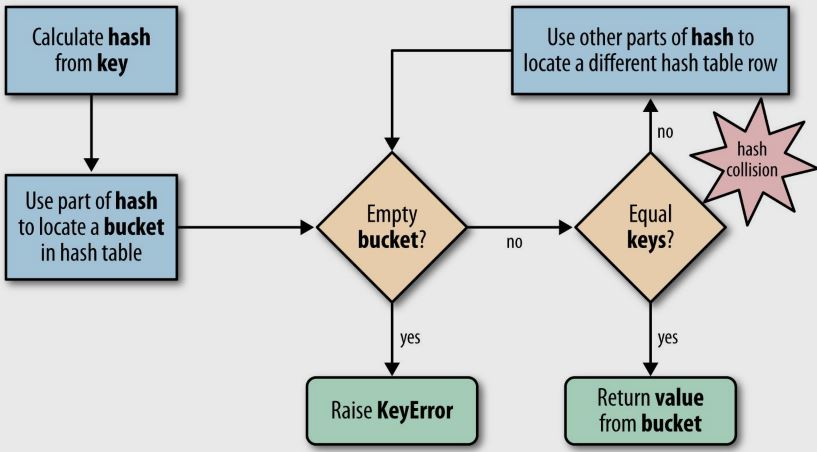

In [8]:
from IPython.display import display, Image

display(Image('Figure 3-3.jpg', width = 750))

*Figure 3-3. Flowchart for retrieving an item from a dict; given a key, this procedure either returns a value or raises KeyError*

The process to insert or update an item is the same, except that when an empty bucket is located, the new item is put there, and when a bucket with a matching key is found, the value in that bucket is overwritten with the new value.

Additionally, when inserting items, Python may determine that the hash table is too crowded and rebuild it to a new location with more room. As the hash table grows, so does the number of hash bits used as bucket offsets, and this keeps the rate of collisions low.

This implementation may seem like a lot of work, but even with millions of items in a `dict`, many searches happen with no collisions, and the average number of collisions per search is between one and two. Under normal usage, even the unluckiest keys can be found after a handful of collisions are resolved.

Knowing the internals of the `dict` implementation we can explain the strengths and limitations of this data structure and all the others derived from it in Python. We are now ready to consider why Python `dicts` behave as they do.

### Practical Consequences of How `dict` Works

In the following subsections, we'll discuss the limitations and benefits that the underlying hash table implementation brings to `dict` usage.

**Keys must be hashable objects**

An object is hashable if all of these requirements are met:
1. It supports the `hash()` function via a `__hash__()` method that always returns the same value over the lifetime of the object.
2. It supports equality via an `__eq__()` method.
3. If `a == b` is `True` then `hash(a) == hash(b)` must also be `True`.

User-defined types are hashable by default because their hash value is their `id()` and they all compare not equal.

**Warning**: If you implement a class with a custom `__eq__` method, and you want the instances to be hashable, you must also implement a suitable `__hash__`, to make sure that when `a == b` is `True` then `hash(a) == hash(b)` is also `True`. Otherwise you are breaking an invariant of the hash table algorithm, with the grave consequence that dicts and sets will not handle your objects reliably. On the other hand, if a class has a custom `__eq$__` that depends on mutable state, its instances are not hashable and you must never implement a `__hash__` method on such a class.

**dicts have significant memory overhead**

Because a `dict` uses a hash tabale internally, and hash tables must be sparse to work, they are not space efficient. For example, if you are handling a large quantity of records, it makes sense to store them in a list of tuples or named tuples instead of using a list of dictionaries in JSON style, with one `dict` per record. Replacing dicts with tuples reduces the memory usage in two ways: by removing the overhead of one hash table per record and by not storing the field names again with each record.

For user-defined types, the `__slots__` class attribute changes the storage of instance attributes from a `dict` to a tuple in each instance. This will be discussed in "Saving Space with the `__slots__` Class Attribute" (Chapter 9).

Keep in mind we are talking about space optimizations. If you are dealing with a few million objects and your machine has gigabytes of RAM, you should postpone such optimizations until they are actually warranted. Optimization is the altar where maintainability is sacrificed.

**Key search is very fast**

The `dict` implementation is an example of trading space for time: dictionaries have significant memory overhead, but they provide fast acess regardless of the size of the dictionary - as long as it fits in memory. As Table 3-5 shows, when we increased the size of a `dict` from 1,000 to 10,000,000 elements, the time to search grew by a factor of 2.8, from 0.000163s to 0.000456s. The latter figure means we could search more than 2 million keys per second in a `dict` with 10 million items.

**Key ordering depends on insertion order**

When a hash collision happens, the second key ends up in a position that it would not normally occupy if it had been inserted first. So, a `dict` built as `dict([(key1, value1), (key2, value2)])` compares equal to `dict([(key2, value2), (key1, value1)])`, but their key ordering may not be the same if the hashes of `key1` and `key2` collide.

Example 3-17 demonstrates the effect of loading three dicts with the same data, just in different order. The resulting dictionaries all compare equal, even if their order is not the same.

*Example 3-17. dialcodes.py fills three dictionaries with the same data sorted in different ways*

In [9]:
# dial codes of the top 10 most populous countries

DIAL_CODES = [
    (86, 'China'),
    (91, 'India'),
    (1, 'United States'),
    (62, 'Indonesia'),
    (55, 'Brazil'),
    (92, 'Pakistan'),
    (880, 'Bangladesh'),
    (234, 'Nigeria'),
    (7, 'Russia'),
    (81, 'Japan'),
]

d1 = dict(DIAL_CODES)
print('d1:', d1.keys())
d2 = dict(sorted(DIAL_CODES))
print('d2:', d2.keys())
d3 = dict(sorted(DIAL_CODES, key=lambda x:x[1]))
print('d3:', d3.keys())
assert d1 == d2 and d2 == d3

d1: dict_keys([86, 91, 1, 62, 55, 92, 880, 234, 7, 81])
d2: dict_keys([1, 7, 55, 62, 81, 86, 91, 92, 234, 880])
d3: dict_keys([880, 55, 86, 91, 62, 81, 234, 92, 7, 1])


**Adding items to a dict may change the order of existing keys**

Whenever you add a new item to a `dict`, the Python interpreter may decide that the hash table of that dictionary needs to grow. This entails building a new, bigger hash table, and adding all current items to the new table. During this process, new (but different) hash collisions may happen, with the result that the keys are likely to be ordered differently in the new hash table. All of this is implementation-dependent, so you cannot reliably predict when it will happen. If you are iterating over the dictionary keys and changing them at the same time, your loop may not scan all the items as expected - not even the items that were already in the dictionary before you added to it.

This is why modifying the contents of a `dict` while iterating through it is a bad idea. If you need to scan and add items to a dictionary, do it in two steps: read the `dict` from start to finish and collect the needed additions in a second `dict`. Then update the first one with it.

**Tip**: In Python 3, the `.keys()`, `.items()`, and `.values()` methods return dictionary views, which behave more like sets than the lists returned by these methods in Python 2. Such views are also dynamic: they do not replicate the contents of the `dict`, and they immediately reflect any changes to the `dict`.

We can now apply what we know about hash tables to sets.

### How Sets Work - Practical Consequences

The `set` and `frozenset` types are also implemented with a has table, except that each bucket holds only a reference to the element (as if it were a key in a `dict`, but without a value to go with it). In fact, before `set` was added to the language, we often used dictionaries with dummy values just to perform fast membership tests on the keys.

Everything said in "Practical Consequences of How dict Works" about how the underlying hash table determines the behavior of a `dict` applies to a `set`. Without repeating the previous section, we can summarize it for sets with just a few words:

- Set elements must be hashable objects.
- Sets have a significant memory overhead.
- Membership testing is very efficient.
- Element ordering depends on insertion order.
- Adding elements to a set may change the order of other elements.

## Chapter Summary

Dictionaries are a keystone of Python. Beyond the basic `dict`, the standard library offers handy, ready-to-use specialized mappings like `defaultdict`, `OrderedDict`, `ChainMap`, and `Counter`, all defined in the `collections` module. The same module also provides the easy-to-extend `UserDict` class.

Two powerful methods available in most mappings are `setdefault` and `update`. The `setdefault` method is used to update items holding mutable values, for example, in a `dict` of `list` values, to avoid redundant searches for the same key. The `update` method allows bulk insertion or overwriting of items from any other mapping, from iterables providing `(key, value)` pairs and from keyword arguments. Mapping constructors also use `update` internally, allowing instances to be initialized from mappings, iterables, or keyword arguments.

A clever hook in the mapping API is the `__missing__` method, which lets you customize what happens when a key is not found.

The `collections.abc` module provides the `Mapping` and `MutableMapping` abstract base classes for reference and type checking. The little-known `MappingProxyType` from the `types` module creates immutable mappings. There are also ABC's for `Set` and `MutableSet`.

The has table implementation underlying `dict` and `set` is extremely fast. Understanding its logic explains why items are apparently unordered and may even be reordered behind our backs. There is a price to pay for all this speed, which is the memory.

# Chapter 4. Text versus Bytes